# Bonus Quest

**Difficulty:** A

**Description:** Students are in a tough spot after changing the grading formula for assignments and now fear taking the exam without a 3.5 GPA. The system gives players a chance to raise their score by completing this bonus quest. This is your Solo Leveling. Survive at all costs. Good luck!

**Goal:** Complete the bonus assignment created by Andrei and corrected by Max.

**Deliverables:**
- Jupyter Notebook (ipynb) file with solution and all cell outputs
- CSV file with model predictions
- Both files uploaded to GitHub repository

**Reward:**
- Bonus points for the Assignment part.
- Title “The one who overcomes the difficulties of fate.”
- +1000 EXP in mastering sklearn
- Skill Upgrade «ML Engineering Lv.2»
- Special Item: [???]

---

## Problem Statement

As a dataset, use Russian news from Balto-Slavic Natural Language Processing 2019 (helsinki.fi). Entities of interest: PER, ORG, LOC, EVT, PRO (see Guidelines_20190122.pdf (helsinki.fi)).

It is sufficient to use 9 documents about Brexit from the sample provided by the organizers.

## Approach

This assignment combines traditional ML methods (using scikit-learn) with modern LLM-based approaches (DeepSeek) for comparison. You will:
1. Formulate the problem as a machine learning task
2. Prepare features and split data appropriately
3. Train and compare multiple models using scikit-learn
4. Evaluate models using proper train/test splits
5. Compare ML model performance with DeepSeek responses
6. Analyze results in terms of course concepts (bias-variance tradeoff, overfitting, generalization)


Example of one document:

ru-10

ru

2018-09-20

https://rg.ru/2018/09/20/tereza-mej-rasschityvaet-usidet-v-sedle-do-zaversheniia-procedury-brexit.html

Theresa May expects to stay in the saddle until the completion of the Brexit procedure
However, according to British media reports, at the upcoming Conservative Party conference at the end of September, May's opponents will give her a serious fight, from which it is not certain that she will emerge victorious. The bookmakers' favorite as a possible replacement for the current prime minister, former British Foreign Secretary Boris Johnson intends to deliver an alternative report that will leave no stone unturned from the government's views on the conditions of "Brexit". From Johnson's point of view, "London has wrapped the British constitution in a suicide belt and handed the detonator to Michel Barnier (Brussels' chief Brexit negotiator. - Ed.)". It is with this metaphor that the head of the British government will have to fight at the conference.


### Task 1
**Problem Formulation & ML Perspective**

Describe the task from both NLP and ML perspectives:
- What kind of machine learning problem is this? (classification, sequence labeling, etc.)
- How can this be formulated as a supervised learning problem?
- What classical ML methods exist for solving it? (e.g., logistic regression, naive Bayes, SVM with text features)
- How can it be solved using modern LLMs like DeepSeek?
- What are the assumptions of different model classes? (e.g., linear models vs. more complex approaches)
- How is model quality typically evaluated in this task? What metrics are appropriate and why?


### Task 1 ответ

* **Тип задачи (NLP/ML):** NER — извлечение именованных сущностей; в ML это обычно **разметка последовательности (sequence labeling)**: каждому токену ставится метка (например, BIO).

* **Supervised-постановка:** вход = текст → токены; выход = последовательность меток `B-PER/I-PER/.../O` (или похожая схема).

* **Классические методы:**

  * токен-классификация в sklearn: **логистическая регрессия / линейный SVM / наивный Байес** на ручных признаках (окно контекста, char-n-граммы, капитализация и т.д.);
  * **CRF (linear-chain)** для учёта зависимостей между соседними метками.

* **Современный подход (LLM/DeepSeek):** промпт “вытащи все PER/ORG/LOC/EVT/PRO” и попросить **строгий JSON** (удобно парсить и сравнивать), затем пост-обработка (дедупликация, нормализация).

* **Предположения моделей:**

  * **Naive Bayes:** условная независимость признаков при фиксированном классе.
  * **Линейные модели:** “линейная разделимость” в пространстве признаков (качество сильно зависит от фичей).
  * **CRF:** метки зависят друг от друга (структурное предсказание), а не независимая классификация токенов.
  * **LLM:** опирается на предобучение и инструкцию; риск “галлюцинаций”, зато меньше фич-инжиниринга.

* **Оценка качества:** обычно **entity-level Precision/Recall/F1**, часто в стиле CoNLL (важно правильно угадать сущность как единицу, а не только токены).

### Task 2
**Data Loading & Preparation**

Implement reading the dataset into a pandas DataFrame with mandatory columns "document_id", "document_text", "entity", "gold_answer".

Then prepare the data for ML:
- Create features from text (e.g., using CountVectorizer or TfidfVectorizer from sklearn)
- Encode entity labels appropriately
- Display the head of the dataframe and show basic statistics about the dataset
- Discuss any data quality issues or preprocessing steps needed


## Task 2 — Data Loading & Preparation

Ниже я:
1) Читаю документы BSNLP (первые 5 строк — метаданные, с 6-й строки — текст).
2) Читаю gold-аннотации (строки вида: `mention<TAB>lemma<TAB>type<TAB>id`).
3) Собираю `DataFrame` с обязательными колонками: `document_id`, `document_text`, `entity`, `gold_answer`.
4) Делаю базовую предобработку (trim, удаление пустых/дубликатов) и вывожу `head()` + статистики.
5) Готовлю данные для ML: создаю `text_for_ml` (упоминание + локальный контекст), строю TF-IDF признаки и кодирую метки через `LabelEncoder`.

Замечания по качеству данных/предобработке:
- В текстах могут быть шум/обрывки из HTML (меню, подписи и т.п.) → полезно чистить/нормализовать пробелы.
- Оценивание обычно case-insensitive → можно приводить сущности к одному регистру при сравнении/дедупликации.
- В пределах одного документа возможны повторяющиеся упоминания → дедупликация по (`document_id`, `entity`, `gold_answer`) уменьшает шум.

In [13]:
from pathlib import Path
import re
import pandas as pd
from IPython.display import display

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# === Путь к распакованному sample ===
UNZIPPED_DIR = Path(r"D:\HSE\3_cource\нейронка\HW5\sample_pl_cs_ru_bg")
RAW_DIR = UNZIPPED_DIR / "raw" / "ru"
ANN_DIR = UNZIPPED_DIR / "annotated" / "ru"

N_DOCS = 9
KEEP_TYPES = {"PER", "ORG", "LOC", "EVT", "PRO", "PROD"}

def read_text_smart(path: Path) -> str:
    for enc in ("utf-8-sig", "utf-8", "cp1251"):
        try:
            return path.read_text(encoding=enc, errors="strict")
        except Exception:
            pass
    return path.read_text(encoding="utf-8", errors="replace")

def norm(s: str) -> str:
    return s.replace("\ufeff", "").strip()

def parse_document(doc_path: Path):
    lines = read_text_smart(doc_path).splitlines()
    doc_id = norm(lines[0]) if lines else doc_path.stem
    doc_text = "\n".join(lines[5:]).strip() if len(lines) > 5 else ""
    return doc_id, doc_text

def parse_annotations(ann_path: Path):
    lines = read_text_smart(ann_path).splitlines()
    doc_id = norm(lines[0]) if lines else ann_path.stem
    recs = []
    for ln in lines[1:]:
        ln = ln.strip()
        if not ln:
            continue
        parts = ln.split("\t")
        if len(parts) < 3:
            continue
        mention = parts[0].strip()
        cat = parts[2].strip().upper()
        if cat not in KEEP_TYPES:
            continue
        if cat == "PROD":
            cat = "PRO"
        if mention and cat:
            recs.append((mention, cat))
    return doc_id, recs

def extract_context(text: str, ent: str, window: int = 80) -> str:
    m = re.search(re.escape(ent), text, flags=re.IGNORECASE)
    if not m:
        return ent
    start = max(0, m.start() - window)
    end = min(len(text), m.end() + window)
    return text[start:end]

# === 1) Проверки ===
if not RAW_DIR.exists():
    raise FileNotFoundError(f"RAW_DIR not found: {RAW_DIR}")
if not ANN_DIR.exists():
    raise FileNotFoundError(f"ANN_DIR not found: {ANN_DIR}")

# === 2) Берём 9 документов ===
raw_files = sorted(RAW_DIR.glob("*.txt"))[:N_DOCS]
print("RU raw files selected:", len(raw_files))

# === 3) Сбор строк датасета ===
rows = []
missing_ann = []

for doc_path in raw_files:
    doc_id, doc_text = parse_document(doc_path)

    # ✅ FIX: меняем только СУФФИКС, а не все вхождения ".txt" в имени
    ann_name = doc_path.with_suffix(".out").name
    ann_path = ANN_DIR / ann_name

    if not ann_path.exists():
        missing_ann.append(ann_name)
        continue

    _, ents = parse_annotations(ann_path)
    for ent, label in ents:
        rows.append({
            "document_id": doc_id,
            "document_text": doc_text,
            "entity": ent,
            "gold_answer": label
        })

df = pd.DataFrame(rows, columns=["document_id", "document_text", "entity", "gold_answer"])

# === 4) Предобработка + head + статистики ===
df["entity"] = df["entity"].astype(str).str.strip()
df["gold_answer"] = df["gold_answer"].astype(str).str.strip().str.upper()
df = df[df["entity"].ne("") & df["gold_answer"].ne("")]
df = df.drop_duplicates(subset=["document_id", "entity", "gold_answer"]).reset_index(drop=True)

print("Loaded docs:", df["document_id"].nunique())
print("Rows (mentions):", len(df))
if missing_ann:
    print("WARNING: missing .out files (first 10):", missing_ann[:10])

display(df.head())

print("\nLabel distribution:")
display(df["gold_answer"].value_counts())

df["doc_len_chars"] = df["document_text"].str.len()
df["entity_len_chars"] = df["entity"].str.len()
print("\nDoc length stats (chars):")
display(df["doc_len_chars"].describe())
print("\nMentions per doc stats:")
display(df.groupby("document_id").size().describe())

# === 5) Признаки + кодирование меток ===
if df.empty:
    raise RuntimeError("df пустой: проверь, что в annotated/ru есть .out для выбранных raw/ru документов.")

df["text_for_ml"] = [
    f"{ent} ||| {extract_context(txt, ent)}"
    for ent, txt in zip(df["entity"], df["document_text"])
]

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=20000)
X = vectorizer.fit_transform(df["text_for_ml"])

le = LabelEncoder()
y = le.fit_transform(df["gold_answer"])

print("\nX shape:", X.shape)
print("Classes:", list(le.classes_))

RU raw files selected: 9
Loaded docs: 9
Rows (mentions): 151


,document_id,document_text,entity,gold_answer
0,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Brexit,EVT
1,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Альбиона,LOC
2,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Альбионе,LOC
3,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Борис Джонсон,PER
4,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",Британии,LOC



Label distribution:


gold_answer
PER    62
LOC    36
ORG    35
EVT    13
PRO     5
Name: count, dtype: int64


Doc length stats (chars):


count     151.000000
mean     2105.774834
std      1942.636031
min       316.000000
25%       778.000000
50%      1028.000000
75%      5088.000000
max      5088.000000
Name: doc_len_chars, dtype: float64


Mentions per doc stats:


count     9.000000
mean     16.777778
std      10.779353
min       7.000000
25%      13.000000
50%      14.000000
75%      18.000000
max      44.000000
dtype: float64


X shape: (151, 1967)
Classes: ['EVT', 'LOC', 'ORG', 'PER', 'PRO']


### Task 3
**Train/Test Split & Data Splitting Strategy**

Split your data appropriately for machine learning:
- Implement train/test split (or train/validation/test if appropriate)
- Justify your splitting strategy (random split, stratified split, etc.)
- Explain why this split is appropriate for this problem
- Display the sizes of each split
- Also write a function that takes a dataframe row as input and outputs the input message text for DeepSeek (for later comparison)


## Task 3 — Train/Test Split & Splitting Strategy

**Стратегия разбиения:** делаю split **по document_id (group split)**, чтобы избежать утечки данных: строки датасета — это упоминания сущностей, и один и тот же `document_text` повторяется много раз для одного документа. Если делить случайно по строкам, один документ окажется и в train, и в test → метрики станут слишком оптимистичными.

Использую `GroupShuffleSplit` (train/test) и ещё один `GroupShuffleSplit` внутри train (train/val).  
Это корректно для оценки обобщения “на новые документы”. Также важно: векторизатор/кодировщик меток **fit только на train**, затем `transform` на val/test (иначе leakage).


In [15]:
import re
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# =========================
# Task 3 — Split + DeepSeek prompt
# =========================

# ---- checks ----
required_cols = {"document_id", "document_text", "entity", "gold_answer"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"df is missing required columns: {missing}")

if df.empty:
    raise ValueError("df is empty — run Task 2 first.")

# ---- context extraction (uses your extract_context if it exists; otherwise defines a fallback) ----
if "extract_context" not in globals():
    def extract_context(text: str, ent: str, window: int = 80) -> str:
        m = re.search(re.escape(ent), text, flags=re.IGNORECASE)
        if not m:
            return ent
        start = max(0, m.start() - window)
        end = min(len(text), m.end() + window)
        return text[start:end]

# ---- create text_for_ml if not present ----
if "text_for_ml" not in df.columns:
    df = df.copy()
    df["text_for_ml"] = [
        f"{ent} ||| {extract_context(txt, ent, window=120)}"
        for ent, txt in zip(df["entity"].astype(str), df["document_text"].astype(str))
    ]

# ---- group split by document_id (avoid leakage) ----
n_docs = df["document_id"].nunique()
test_groups = 2 if n_docs >= 3 else 1
val_groups = 1 if n_docs >= (test_groups + 2) else 0  # если слишком мало документов — без val

groups = df["document_id"].values

gss = GroupShuffleSplit(n_splits=1, test_size=test_groups, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=groups))
df_train = df.iloc[train_idx].reset_index(drop=True)
df_test  = df.iloc[test_idx].reset_index(drop=True)

if val_groups > 0:
    gss2 = GroupShuffleSplit(n_splits=1, test_size=val_groups, random_state=43)
    tr_idx, val_idx = next(gss2.split(df_train, groups=df_train["document_id"].values))
    df_tr  = df_train.iloc[tr_idx].reset_index(drop=True)
    df_val = df_train.iloc[val_idx].reset_index(drop=True)
else:
    df_tr = df_train
    df_val = pd.DataFrame(columns=df.columns)

print("Split sizes (rows):")
print(" train:", len(df_tr), " | val:", len(df_val), " | test:", len(df_test))

print("\nSplit sizes (docs):")
print(" train docs:", df_tr["document_id"].nunique(),
      "| val docs:", df_val["document_id"].nunique(),
      "| test docs:", df_test["document_id"].nunique())

print("\nDoc IDs per split:")
print(" train:", sorted(df_tr["document_id"].unique()))
print(" val  :", sorted(df_val["document_id"].unique()) if len(df_val) else [])
print(" test :", sorted(df_test["document_id"].unique()))

# ---- fit vectorizer/encoder ONLY on train (avoid leakage) ----
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=20000)
X_tr = vectorizer.fit_transform(df_tr["text_for_ml"])

X_val = vectorizer.transform(df_val["text_for_ml"]) if len(df_val) else None
X_te  = vectorizer.transform(df_test["text_for_ml"])

le = LabelEncoder()
y_tr = le.fit_transform(df_tr["gold_answer"])

y_val = le.transform(df_val["gold_answer"]) if len(df_val) else None
y_te  = le.transform(df_test["gold_answer"])

print("\nX shapes:",
      X_tr.shape,
      (X_val.shape if X_val is not None else None),
      X_te.shape)
print("Classes:", list(le.classes_))

# ---- DeepSeek prompt function ----
def deepseek_message(row, window=120, fallback_chars=600) -> str:
    """
    row: pd.Series (a row from df/df_tr/df_val/df_test)
    Returns a prompt text for DeepSeek (later comparison).
    Expected model output: exactly one label from {PER, ORG, LOC, EVT, PRO}.
    """
    ent = str(row["entity"])
    doc = str(row["document_text"])
    ctx = extract_context(doc, ent, window=window)

    # if context extraction failed (returned only the entity), provide a larger fallback
    if ctx.strip().lower() == ent.strip().lower():
        ctx = doc[:fallback_chars]

    return (
        "Определи тип сущности упоминания по контексту.\n"
        "Возможные типы: PER, ORG, LOC, EVT, PRO.\n"
        "Ответь строго одной меткой (без пояснений).\n\n"
        f"Упоминание: {ent}\n"
        f"Контекст: {ctx}\n"
        "Ответ:"
    )

# example prompt
print("\nDeepSeek prompt example:\n")
print(deepseek_message(df_tr.iloc[0]))

Split sizes (rows):
 train: 109  | val: 10  | test: 32

Split sizes (docs):
 train docs: 6 | val docs: 1 | test docs: 2

Doc IDs per split:
 train: ['ru-10', 'ru-1001', 'ru-1002', 'ru-1004', 'ru-1006', 'ru-1017']
 val  : ['ru-1003']
 test : ['ru-1000', 'ru-1011']

X shapes: (109, 1597) (10, 1597) (32, 1597)
Classes: ['EVT', 'LOC', 'ORG', 'PER', 'PRO']

DeepSeek prompt example:

Определи тип сущности упоминания по контексту.
Возможные типы: PER, ORG, LOC, EVT, PRO.
Ответь строго одной меткой (без пояснений).

Упоминание: Brexit
Контекст: Тем не менее, по сведениям британских СМИ, на предстоящей в конце сентября конференции партии тори противники Мэй навяжут ей серьезный бой, из которого не факт, что она выйдет победителем. Фаворит букмекеров в качестве возможного сменщика нынешнего премьера, бывший министр иностранных дел Британии Борис Джонсон намерен выступить с альтернативным докладом, который не оставит камня на камне от взглядов главы правительства на условия "брекзита". С точки зр

EVT

### Task 4
**Model Training with scikit-learn**

Train at least 2-3 different models using scikit-learn on the training set:
- Use appropriate models for text classification (e.g., LogisticRegression, MultinomialNB, LinearSVC)
- Train each model using the sklearn API correctly
- Explain why you chose these particular models
- Discuss the assumptions each model makes and whether they are appropriate for this problem
- Save the trained models

**Also (for comparison):** Get DeepSeek responses for all documents. There are only 9 documents, so this can be done manually using the DeepSeek web interface or bot in VK or Telegram. Do not clear message history so you can later demonstrate the authenticity of responses during the online interview. Add DeepSeek responses to the dataframe.


## Task 4 — Model Training (scikit-learn) + DeepSeek comparison

### Почему эти модели
Обучаю 3 baseline-модели для классификации текста на TF-IDF:
- **LogisticRegression** — линейный baseline с регуляризацией.
- **LinearSVC** — сильный baseline для разреженных текстовых признаков.
- **MultinomialNB** — быстрый вероятностный baseline.

### Допущения моделей
- **LogReg / LinearSVC:** линейная разделимость в пространстве TF-IDF (часто подходит для текста).
- **MultinomialNB:** условная независимость признаков (грубое допущение), но как baseline полезно.

### Сохранение
Сохраняю модели + `tfidf_vectorizer` + `label_encoder` через `joblib`, чтобы воспроизводить результаты.

### DeepSeek (сравнение)
Документов всего 9, поэтому ответы DeepSeek получены вручную в чате (историю не очищаю).
Ответы сохраняю как `deepseek_raw`, парсю и получаю `deepseek_pred` для строк `df`.

In [25]:
import os
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report
from joblib import dump

# Требуются переменные из Task 3:
# df_tr, df_val, df_test, X_tr, X_val, X_te, y_tr, y_val, y_te, vectorizer, le
for name in ["df_tr","df_val","df_test","X_tr","X_val","X_te","y_tr","y_val","y_te","vectorizer","le"]:
    if name not in globals():
        raise ValueError(f"Missing `{name}`. Run Task 2 + Task 3 first.")

labels_all = np.arange(len(le.classes_))  # все классы encoder’а
has_val = (X_val is not None) and (y_val is not None) and (len(df_val) > 0)

models = {
    "logreg": LogisticRegression(max_iter=3000, class_weight="balanced"),
    "linearsvc": LinearSVC(class_weight="balanced"),
    "mnb": MultinomialNB(alpha=0.5),
}

results = []
trained = {}

for name, clf in models.items():
    clf.fit(X_tr, y_tr)
    trained[name] = clf

    if has_val:
        pred_val = clf.predict(X_val)
        f1_macro = f1_score(y_val, pred_val, labels=labels_all, average="macro", zero_division=0)
        f1_micro = f1_score(y_val, pred_val, labels=labels_all, average="micro", zero_division=0)

        results.append({"model": name, "f1_macro": f1_macro, "f1_micro": f1_micro})
        print(f"\n=== {name} (VAL) ===")
        print(classification_report(
            y_val, pred_val,
            labels=labels_all,
            target_names=le.classes_,
            digits=3,
            zero_division=0
        ))
    else:
        results.append({"model": name, "f1_macro": np.nan, "f1_micro": np.nan})
        print(f"\n=== {name} === trained (no VAL)")

results_df = pd.DataFrame(results).sort_values("f1_macro", ascending=False, na_position="last").reset_index(drop=True)
print("\nModel comparison (VAL):")
try:
    display(results_df)
except NameError:
    print(results_df)

best_name = results_df.iloc[0]["model"] if has_val else "linearsvc"
best_model = trained[best_name]
print("\nBest model:", best_name)

pred_test = best_model.predict(X_te)
print(f"\n=== {best_name} (TEST) ===")
print(classification_report(
    y_te, pred_test,
    labels=labels_all,
    target_names=le.classes_,
    digits=3,
    zero_division=0
))

OUT_DIR = "models"
os.makedirs(OUT_DIR, exist_ok=True)

dump(vectorizer, os.path.join(OUT_DIR, "tfidf_vectorizer.joblib"))
dump(le, os.path.join(OUT_DIR, "label_encoder.joblib"))
for name, clf in trained.items():
    dump(clf, os.path.join(OUT_DIR, f"{name}.joblib"))

print(f"\nSaved: ./{OUT_DIR}/ (vectorizer, label_encoder, {len(trained)} models)")


=== logreg (VAL) ===
              precision    recall  f1-score   support

         EVT      0.250     1.000     0.400         1
         LOC      0.000     0.000     0.000         2
         ORG      0.000     0.000     0.000         2
         PER      0.667     0.800     0.727         5
         PRO      0.000     0.000     0.000         0

    accuracy                          0.500        10
   macro avg      0.183     0.360     0.225        10
weighted avg      0.358     0.500     0.404        10


=== linearsvc (VAL) ===
              precision    recall  f1-score   support

         EVT      0.500     1.000     0.667         1
         LOC      0.000     0.000     0.000         2
         ORG      1.000     0.500     0.667         2
         PER      0.714     1.000     0.833         5
         PRO      0.000     0.000     0.000         0

    accuracy                          0.700        10
   macro avg      0.443     0.500     0.433        10
weighted avg      0.607     0.

,model,f1_macro,f1_micro
0,linearsvc,0.433333,0.7
1,logreg,0.225455,0.5
2,mnb,0.133333,0.5



Best model: linearsvc

=== linearsvc (TEST) ===
              precision    recall  f1-score   support

         EVT      1.000     1.000     1.000         2
         LOC      0.000     0.000     0.000         3
         ORG      0.300     0.500     0.375         6
         PER      0.750     0.500     0.600        18
         PRO      0.333     0.667     0.444         3

    accuracy                          0.500        32
   macro avg      0.477     0.533     0.484        32
weighted avg      0.572     0.500     0.512        32


Saved: ./models/ (vectorizer, label_encoder, 3 models)


In [26]:
import json
import re
from sklearn.metrics import classification_report

DOC_ORDER = ["ru-10","ru-1001","ru-1002","ru-1004","ru-1006","ru-1017","ru-1003","ru-1000","ru-1011"]

DEEPSEEK_TEXTS = [
r'''{
    "PER": ["Мэй", "Борис Джонсон", "Мишелю Барнье", "Терезу", "Себастьян Курц"],
    "ORG": ["Евросоюза", "Евросоюзом", "Еврокомиссия", "Консервативной партии", "Европейскому и британскому парламентам", "лейбористы", "МВФ"],
    "LOC": ["Британии", "Лондон", "Брюсселю", "Брюсселя", "Брюсселе", "Северную Ирландию", "Соединенного Королевства", "Альбиона", "Альбионе", "Ла-Манша"],
    "EVT": ["брекзита", "брекзит", "брекзиту", "брексит", "саммите Евросоюза", "конференции партии тори", "конференции Консервативной партии", "конференции тори"],
    "PRO": []
}''',
r'''{
    "PER": ["Борис Джонсон", "Тереза Мэй"],
    "ORG": ["Associated Press", "Евросоюза", "ЕС"],
    "LOC": ["Великобритании", "Соединенного Королевства"],
    "EVT": ["Brexit"],
    "PRO": []
}''',
r'''{
    "PER": ["Тереза Мей", "Бориса Джонсона", "Дэвид Дэвис"],
    "ORG": ["ЕС", "Евросоюза"],
    "LOC": ["Великобритании"],
    "EVT": ["Брекзит"],
    "PRO": []
}''',
r'''{
    "PER": ["Борис Джонсон", "Терезы Мэй", "Дэвид Дэвис"],
    "ORG": ["МИД Великобритании", "ТАСС", "Евросоюзом", "ЕС", "Консервативной партии"],
    "LOC": ["Лондоне"],
    "EVT": ["Brexit"],
    "PRO": []
}''',
r'''{
    "PER": ["Мария Захарова", "Бориса Джонсона", "Т. Мэй"],
    "ORG": ["МИД России", "Facebook"],
    "LOC": ["Великобритании", "Британии"],
    "EVT": ["Brexit"],
    "PRO": []
}''',
r'''{
    "PER": ["Борис Джонсон", "Дэвид Дэвис", "Стив Бейкер", "Тереза Мэй"],
    "ORG": ["УНН", "The Guardian", "британского парламента", "ЕС"],
    "LOC": ["КИЕВ", "Великобритании", "Соединенного Королевства"],
    "EVT": ["Brexit"],
    "PRO": []
}''',
r'''{
    "PER": ["Тереза Мэй", "Джонсона", "Борис Джонсон", "Дэвид Дэвис"],
    "ORG": ["Рейтер"],
    "LOC": ["Великобритании"],
    "EVT": ["брекзита"],
    "PRO": []
}''',
r'''{
    "PER": ["Джонсон", "Дэвид Дэвис", "Стив Бейкер", "Тереза Мэй", "Бориса Джонсона"],
    "ORG": ["ЕС", "The Guardian", "УНН", "британского парламента"],
    "LOC": ["Великобритании", "Соединенного Королевства"],
    "EVT": ["Brexit"],
    "PRO": []
}''',
r'''{
    "PER": ["Бориса Джонсона", "Терезы Мэй", "Дэвид Дэвис"],
    "ORG": ["ЕС", "The Guardian", "Палате общин", "Евросоюза"],
    "LOC": ["Великобритании"],
    "EVT": ["Brexit"],
    "PRO": []
}'''
]

assert len(DOC_ORDER) == len(DEEPSEEK_TEXTS) == 9
DEEPSEEK_RAW = {doc_id: txt.strip() for doc_id, txt in zip(DOC_ORDER, DEEPSEEK_TEXTS)}

if "df" not in globals():
    raise ValueError("Missing global `df` (Task 2).")

df["deepseek_raw"] = df["document_id"].map(DEEPSEEK_RAW).fillna("")

def _norm(s: str) -> str:
    return " ".join(str(s).strip().lower().split())

def _strip_fences(s: str) -> str:
    s = s.strip()
    s = re.sub(r"^\s*```(?:json)?\s*", "", s, flags=re.IGNORECASE)
    s = re.sub(r"\s*```\s*$", "", s)
    return s.strip()

doc_maps = {}
for doc_id, raw in DEEPSEEK_RAW.items():
    obj = json.loads(_strip_fences(raw))
    m = {}
    for label in ["PER","ORG","LOC","EVT","PRO"]:
        for ent in (obj.get(label, []) or []):
            m.setdefault(_norm(ent), label)
    doc_maps[doc_id] = m

def deepseek_pred_row(row) -> str:
    doc_id = row["document_id"]
    gold_n = _norm(row["entity"])
    m = doc_maps.get(doc_id, {})
    if gold_n in m:
        return m[gold_n]

    best_label, best_score = "", 0
    for ent_n, label in m.items():
        if len(ent_n) < 4 or len(gold_n) < 4:
            continue
        if ent_n in gold_n or gold_n in ent_n:
            score = min(len(ent_n), len(gold_n))
            if score > best_score:
                best_label, best_score = label, score
    return best_label

df["deepseek_pred"] = df.apply(deepseek_pred_row, axis=1)

print("DeepSeek attached.")
print("Non-empty deepseek_raw:", (df["deepseek_raw"].str.len() > 0).sum(), "/", len(df))
print("Non-empty deepseek_pred:", (df["deepseek_pred"] != "").sum(), "/", len(df))

if "df_test" in globals():
    tmp = df.merge(
        df_test[["document_id","entity","gold_answer"]],
        on=["document_id","entity","gold_answer"],
        how="inner"
    )
    coverage = (tmp["deepseek_pred"] != "").mean() if len(tmp) else 0.0
    print("\nDeepSeek coverage on TEST:", coverage)

    tmp2 = tmp[tmp["deepseek_pred"] != ""].copy()
    if len(tmp2):
        print(classification_report(
            tmp2["gold_answer"], tmp2["deepseek_pred"],
            labels=["PER","ORG","LOC","EVT","PRO"],
            digits=3,
            zero_division=0
        ))

with open("deepseek_responses.json", "w", encoding="utf-8") as f:
    json.dump(DEEPSEEK_RAW, f, ensure_ascii=False, indent=2)

df.to_csv("df_with_deepseek.csv", index=False, encoding="utf-8")
print("\nSaved: deepseek_responses.json, df_with_deepseek.csv")

DeepSeek attached.
Non-empty deepseek_raw: 151 / 151
Non-empty deepseek_pred: 113 / 151

DeepSeek coverage on TEST: 0.71875
              precision    recall  f1-score   support

         PER      1.000     1.000     1.000        11
         ORG      0.714     0.833     0.769         6
         LOC      0.667     1.000     0.800         2
         EVT      1.000     1.000     1.000         2
         PRO      0.000     0.000     0.000         2

    accuracy                          0.870        23
   macro avg      0.676     0.767     0.714        23
weighted avg      0.810     0.870     0.835        23


Saved: deepseek_responses.json, df_with_deepseek.csv


### Task 5
**Model Evaluation & Metrics**

Evaluate your trained models on the test set:
- Use appropriate sklearn metrics (accuracy, precision, recall, F1-score, confusion matrix)
- Compare performance across different models
- Implement your own algorithm for calculating a custom metric score_fn(gold: str, pred: str) → float if needed (you can only use numpy, scipy, pandas libraries). Write unit tests. Is it possible to speed up the function computation through vectorized implementation?
- Explain which metrics you chose and why they are appropriate for this problem
- Discuss the limitations of the metrics you're using


## Task 5 — Model Evaluation & Metrics

### Метрики
Считаю:
- **Accuracy** — доля правильных ответов (простая и понятная, но может быть обманчива при дисбалансе классов).
- **Precision / Recall / F1** по классам + усреднения (**macro**, **weighted**) — важны при дисбалансе; F1 — гармоническое среднее precision и recall. :contentReference[oaicite:1]{index=1}
- **Balanced accuracy** — среднее recall по классам (полезно при дисбалансе). :contentReference[oaicite:2]{index=2}
- **Confusion matrix** — показывает, какие классы путаются чаще всего. :contentReference[oaicite:3]{index=3}

### Ограничения
- Датасет маленький (9 документов) → высокая дисперсия оценок.
- Классы несбалансированы (например, PRO редкий) → accuracy и weighted-метрики могут быть слишком “оптимистичны”.
- DeepSeek: ответы сущностей не всегда совпадают с gold по словоформам → часть строк не матчится (поэтому считаю coverage отдельно).


In [27]:
import os
import numpy as np
import pandas as pd

from joblib import load
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_recall_fscore_support, f1_score,
    confusion_matrix, classification_report
)

# ---- requirements ----
for name in ["df_test", "le"]:
    if name not in globals():
        raise ValueError(f"Missing `{name}`. Run Tasks 2–4 first.")

# ---- load artifacts from disk (recommended for reproducibility) ----
MODEL_DIR = "models"
vectorizer = load(os.path.join(MODEL_DIR, "tfidf_vectorizer.joblib"))
le = load(os.path.join(MODEL_DIR, "label_encoder.joblib"))

model_files = ["logreg.joblib", "linearsvc.joblib", "mnb.joblib"]
models = {fn.replace(".joblib",""): load(os.path.join(MODEL_DIR, fn)) for fn in model_files}

# ---- build X_test, y_test ----
if "text_for_ml" not in df_test.columns:
    raise ValueError("df_test must contain `text_for_ml` (from Task 2/3).")

X_test = vectorizer.transform(df_test["text_for_ml"])
y_test = le.transform(df_test["gold_answer"])
labels_all = np.arange(len(le.classes_))  # stable order

def evaluate_model(name, clf, X, y, label_names):
    pred = clf.predict(X)

    acc = accuracy_score(y, pred)
    bacc = balanced_accuracy_score(y, pred)

    # macro / weighted metrics
    p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(
        y, pred, labels=labels_all, average="macro", zero_division=0
    )
    p_w, r_w, f_w, _ = precision_recall_fscore_support(
        y, pred, labels=labels_all, average="weighted", zero_division=0
    )

    cm = confusion_matrix(y, pred, labels=labels_all)

    print(f"\n=== {name} (TEST) ===")
    print(classification_report(
        y, pred,
        labels=labels_all,
        target_names=label_names,
        digits=3,
        zero_division=0
    ))

    return {
        "model": name,
        "accuracy": acc,
        "balanced_accuracy": bacc,
        "precision_macro": p_macro,
        "recall_macro": r_macro,
        "f1_macro": f_macro,
        "f1_weighted": f_w,
        "confusion_matrix": cm,
    }

rows = []
cms = {}

for name, clf in models.items():
    out = evaluate_model(name, clf, X_test, y_test, le.classes_)
    cms[name] = out.pop("confusion_matrix")
    rows.append(out)

results_df = pd.DataFrame(rows).sort_values("f1_macro", ascending=False).reset_index(drop=True)
print("\n=== Model comparison on TEST (sorted by f1_macro) ===")
try:
    display(results_df)
except NameError:
    print(results_df)

best_name = results_df.iloc[0]["model"]
print("\nBest by f1_macro:", best_name)

# Show confusion matrix for the best model as a labeled DataFrame
cm_best = pd.DataFrame(cms[best_name], index=le.classes_, columns=le.classes_)
print("\nConfusion matrix (best model):")
try:
    display(cm_best)
except NameError:
    print(cm_best)



=== logreg (TEST) ===
              precision    recall  f1-score   support

         EVT      0.400     1.000     0.571         2
         LOC      0.333     0.333     0.333         3
         ORG      0.300     0.500     0.375         6
         PER      0.909     0.556     0.690        18
         PRO      0.667     0.667     0.667         3

    accuracy                          0.562        32
   macro avg      0.522     0.611     0.527        32
weighted avg      0.686     0.562     0.588        32


=== linearsvc (TEST) ===
              precision    recall  f1-score   support

         EVT      1.000     1.000     1.000         2
         LOC      0.000     0.000     0.000         3
         ORG      0.300     0.500     0.375         6
         PER      0.750     0.500     0.600        18
         PRO      0.333     0.667     0.444         3

    accuracy                          0.500        32
   macro avg      0.477     0.533     0.484        32
weighted avg      0.572     

,model,accuracy,balanced_accuracy,precision_macro,recall_macro,f1_macro,f1_weighted
0,logreg,0.56250,0.611111,0.521818,0.611111,0.527217,0.587708
1,linearsvc,0.50000,0.533333,0.476667,0.533333,0.483889,0.511979
2,mnb,0.53125,0.233333,0.191111,0.233333,0.206061,0.443182



Best by f1_macro: logreg

Confusion matrix (best model):


,EVT,LOC,ORG,PER,PRO
EVT,2,0,0,0,0
LOC,1,1,1,0,0
ORG,1,0,3,1,1
PER,1,1,6,10,0
PRO,0,1,0,0,2


In [28]:
import numpy as np
import pandas as pd

# class weights from TRAIN (лучше, чем из test)
if "df_tr" not in globals():
    raise ValueError("Need df_tr (train split) from Task 3.")

train_counts = df_tr["gold_answer"].value_counts()
class_weights = (1.0 / train_counts).to_dict()  # inverse frequency
# нормализовать не обязательно: мы нормируем в итоговом score

def score_fn(gold: str, pred: str, w: dict) -> float:
    """Per-sample score: weight(gold) if correct else 0.0"""
    if gold not in w:
        raise KeyError(f"Unknown gold label: {gold}")
    return float(w[gold]) if gold == pred else 0.0

def custom_score_loop(golds, preds, w: dict) -> float:
    """Weighted accuracy (loop), normalized by sum of weights of gold labels."""
    s = 0.0
    denom = 0.0
    for g, p in zip(golds, preds):
        denom += float(w[g])
        s += score_fn(g, p, w)
    return s / denom if denom > 0 else 0.0

def custom_score_vectorized(golds, preds, w: dict) -> float:
    """Same metric, vectorized with numpy."""
    golds = np.asarray(golds, dtype=object)
    preds = np.asarray(preds, dtype=object)

    # map gold labels to weights
    # (pandas map is handy and still allowed)
    wg = pd.Series(golds).map(w).to_numpy(dtype=float)
    if np.isnan(wg).any():
        bad = pd.Series(golds)[pd.isna(wg)].unique()
        raise KeyError(f"Unknown gold labels: {bad}")

    correct = (golds == preds).astype(float)
    num = (wg * correct).sum()
    denom = wg.sum()
    return float(num / denom) if denom > 0 else 0.0

# ---- unit tests (simple asserts) ----
def _run_tests():
    w = {"A": 2.0, "B": 1.0}
    gold = ["A","A","B","B"]
    pred_ok = ["A","A","B","B"]
    pred_half = ["A","B","B","A"]

    # perfect => 1.0
    assert abs(custom_score_loop(gold, pred_ok, w) - 1.0) < 1e-12
    assert abs(custom_score_vectorized(gold, pred_ok, w) - 1.0) < 1e-12

    # manual check:
    # weights sum = 2+2+1+1=6
    # correct in pred_half: positions 0 (A), 2 (B) => 2 + 1 = 3 => 3/6 = 0.5
    assert abs(custom_score_loop(gold, pred_half, w) - 0.5) < 1e-12
    assert abs(custom_score_vectorized(gold, pred_half, w) - 0.5) < 1e-12

    # unknown label => error
    try:
        custom_score_vectorized(["C"], ["C"], w)
        raise AssertionError("Expected KeyError for unknown label")
    except KeyError:
        pass

    print("✅ Unit tests passed.")

_run_tests()

print("\nExample class_weights (from train):")
print(class_weights)


✅ Unit tests passed.

Example class_weights (from train):
{'PER': 0.02564102564102564, 'LOC': 0.03225806451612903, 'ORG': 0.037037037037037035, 'EVT': 0.1, 'PRO': 0.5}


In [29]:
from sklearn.metrics import accuracy_score

# predict for each model and compute custom metric
custom_rows = []

for name, clf in models.items():
    pred = clf.predict(X_test)
    gold_str = le.inverse_transform(y_test)
    pred_str = le.inverse_transform(pred)

    cs_loop = custom_score_loop(gold_str, pred_str, class_weights)
    cs_vec  = custom_score_vectorized(gold_str, pred_str, class_weights)

    custom_rows.append({
        "model": name,
        "custom_score_loop": cs_loop,
        "custom_score_vec": cs_vec,
        "custom_score_diff": abs(cs_loop - cs_vec),
    })

custom_df = pd.DataFrame(custom_rows).sort_values("custom_score_vec", ascending=False).reset_index(drop=True)
print("\n=== Custom metric comparison (TEST) ===")
try:
    display(custom_df)
except NameError:
    print(custom_df)

# ---- optional: DeepSeek evaluation (strict + coverage) ----
if "deepseek_pred" in df.columns:
    test_df = df.merge(
        df_test[["document_id","entity","gold_answer"]],
        on=["document_id","entity","gold_answer"],
        how="inner"
    ).copy()

    test_df["has_deepseek"] = test_df["deepseek_pred"].astype(str).str.len().gt(0)
    coverage = test_df["has_deepseek"].mean() if len(test_df) else 0.0

    # (A) strict: empty => wrong (leave as empty label)
    strict_pred = test_df["deepseek_pred"].fillna("").astype(str)
    # map invalid/empty to a dummy label that is always wrong
    dummy = "__NONE__"
    strict_pred2 = strict_pred.where(strict_pred.isin(le.classes_), other=dummy)

    gold = test_df["gold_answer"].astype(str)
    strict_acc = (strict_pred2 == gold).mean()

    print("\n=== DeepSeek on TEST ===")
    print("coverage:", coverage)
    print("strict accuracy (empty treated as wrong):", strict_acc)

    # (B) matched-only: report only where we have a label
    matched = test_df[test_df["has_deepseek"] & test_df["deepseek_pred"].isin(le.classes_)].copy()
    if len(matched):
        print("\nDeepSeek report (matched-only):")
        print(classification_report(
            matched["gold_answer"], matched["deepseek_pred"],
            labels=["PER","ORG","LOC","EVT","PRO"],
            digits=3,
            zero_division=0
        ))
else:
    print("\nNo deepseek_pred column found in df — skip DeepSeek evaluation.")



=== Custom metric comparison (TEST) ===


,model,custom_score_loop,custom_score_vec,custom_score_diff
0,logreg,0.644933,0.644933,2.220446e-16
1,linearsvc,0.621592,0.621592,0.000000e+00
2,mnb,0.184916,0.184916,8.326673e-17



=== DeepSeek on TEST ===
coverage: 0.71875
strict accuracy (empty treated as wrong): 0.625

DeepSeek report (matched-only):
              precision    recall  f1-score   support

         PER      1.000     1.000     1.000        11
         ORG      0.714     0.833     0.769         6
         LOC      0.667     1.000     0.800         2
         EVT      1.000     1.000     1.000         2
         PRO      0.000     0.000     0.000         2

    accuracy                          0.870        23
   macro avg      0.676     0.767     0.714        23
weighted avg      0.810     0.870     0.835        23



In [30]:
# --- save evaluation outputs ---
results_df.to_csv("test_metrics.csv", index=False)
custom_df.to_csv("test_custom_metrics.csv", index=False)

# confusion matrices
for m, cm in cms.items():
    pd.DataFrame(cm, index=le.classes_, columns=le.classes_).to_csv(f"confusion_matrix_{m}.csv")

# per-row predictions on test
gold_str = le.inverse_transform(y_test)
out = df_test[["document_id","entity","gold_answer"]].copy()
out["gold"] = gold_str

for name, clf in models.items():
    pred = le.inverse_transform(clf.predict(X_test))
    out[f"pred_{name}"] = pred

out.to_csv("test_predictions.csv", index=False, encoding="utf-8")
print("Saved: test_metrics.csv, test_custom_metrics.csv, confusion_matrix_*.csv, test_predictions.csv")

Saved: test_metrics.csv, test_custom_metrics.csv, confusion_matrix_*.csv, test_predictions.csv


### Task 6
**Model Comparison & Visualization**

Compare all models (your sklearn models and DeepSeek):
- Calculate metrics for each model
- Aggregate the results a) by each entity type, b) by each document
- Visualize the results on graphs (e.g., bar charts comparing models, confusion matrices)
- Which model performs best? Why might this be?
- Compare train vs test performance for your sklearn models. Are there signs of overfitting or underfitting?
- What conclusions can be drawn about model selection?


## Task 6 — Model Comparison & Visualization

Сравниваю модели:
- sklearn: logreg / linearsvc / mnb
- DeepSeek: по `deepseek_pred` (две оценки: strict и matched-only + coverage)

Считаю и визуализирую:
1) Overall метрики на TRAIN и TEST (accuracy, balanced accuracy, macro-F1, weighted-F1)
2) Метрики по каждому классу (F1 per label)
3) Метрики по каждому документу (accuracy + macro-F1 по меткам, встречающимся в документе)
4) Confusion matrices

Balanced accuracy = средний recall по классам (полезно при дисбалансе). :contentReference[oaicite:1]{index=1}
Macro avg = среднее по классам без весов; Weighted avg = с весами по support. :contentReference[oaicite:2]{index=2}


In [31]:
import os
import numpy as np
import pandas as pd

from joblib import load
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_recall_fscore_support, f1_score,
    confusion_matrix
)

# ---- checks ----
for v in ["df_tr", "df_test"]:
    if v not in globals():
        raise ValueError(f"Missing `{v}`. Run Tasks 2–4 first.")

MODEL_DIR = "models"
vectorizer = load(os.path.join(MODEL_DIR, "tfidf_vectorizer.joblib"))
le = load(os.path.join(MODEL_DIR, "label_encoder.joblib"))

model_files = ["logreg.joblib", "linearsvc.joblib", "mnb.joblib"]
models = {fn.replace(".joblib",""): load(os.path.join(MODEL_DIR, fn)) for fn in model_files}

# matrices
X_tr = vectorizer.transform(df_tr["text_for_ml"])
y_tr = le.transform(df_tr["gold_answer"])

X_te = vectorizer.transform(df_test["text_for_ml"])
y_te = le.transform(df_test["gold_answer"])

labels_all = np.arange(len(le.classes_))
label_names = list(le.classes_)

# predictions
preds = {"train": {}, "test": {}}
for name, clf in models.items():
    preds["train"][name] = clf.predict(X_tr)
    preds["test"][name]  = clf.predict(X_te)

print("Loaded models:", list(models.keys()))
print("Classes:", label_names)
print("Train/Test sizes:", len(df_tr), len(df_test))


Loaded models: ['logreg', 'linearsvc', 'mnb']
Classes: ['EVT', 'LOC', 'ORG', 'PER', 'PRO']
Train/Test sizes: 109 32


,split,model,accuracy,balanced_accuracy,f1_macro,f1_weighted
3,test,logreg,0.562500,0.611111,0.527217,0.587708
4,test,linearsvc,0.500000,0.533333,0.483889,0.511979
5,test,mnb,0.531250,0.233333,0.206061,0.443182
1,train,linearsvc,0.990826,0.992593,0.993695,0.990797
0,train,logreg,0.798165,0.872401,0.726798,0.812176
2,train,mnb,0.779817,0.583044,0.614819,0.773467


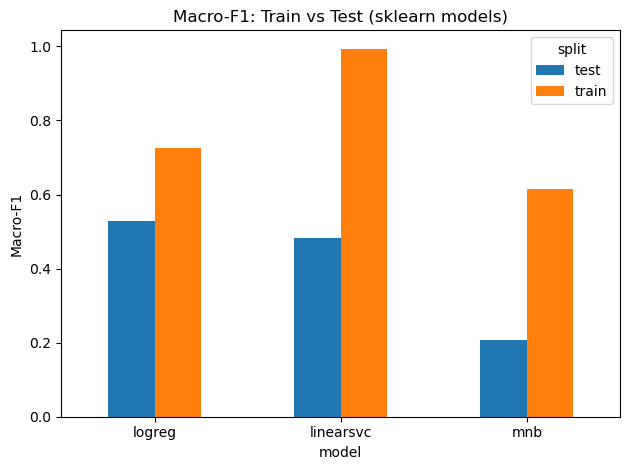

In [32]:
import matplotlib.pyplot as plt

def overall_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, labels=labels_all, average="macro", zero_division=0)
    f1w = f1_score(y_true, y_pred, labels=labels_all, average="weighted", zero_division=0)
    return acc, bacc, f1m, f1w

rows = []
for split, y in [("train", y_tr), ("test", y_te)]:
    for m in models.keys():
        acc, bacc, f1m, f1w = overall_metrics(y, preds[split][m])
        rows.append({
            "split": split,
            "model": m,
            "accuracy": acc,
            "balanced_accuracy": bacc,
            "f1_macro": f1m,
            "f1_weighted": f1w,
        })

overall_df = pd.DataFrame(rows)
display(overall_df.sort_values(["split","f1_macro"], ascending=[True,False]))

# plot: macro-F1 train vs test
pivot = overall_df.pivot(index="model", columns="split", values="f1_macro").loc[list(models.keys())]
pivot.plot(kind="bar")
plt.title("Macro-F1: Train vs Test (sklearn models)")
plt.ylabel("Macro-F1")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


,label,precision,recall,f1,support,model
0,EVT,0.400000,1.000000,0.571429,2,logreg
1,LOC,0.333333,0.333333,0.333333,3,logreg
2,ORG,0.300000,0.500000,0.375000,6,logreg
3,PER,0.909091,0.555556,0.689655,18,logreg
4,PRO,0.666667,0.666667,0.666667,3,logreg
5,EVT,1.000000,1.000000,1.000000,2,linearsvc
6,LOC,0.000000,0.000000,0.000000,3,linearsvc
7,ORG,0.300000,0.500000,0.375000,6,linearsvc
8,PER,0.750000,0.500000,0.600000,18,linearsvc
9,PRO,0.333333,0.666667,0.444444,3,linearsvc


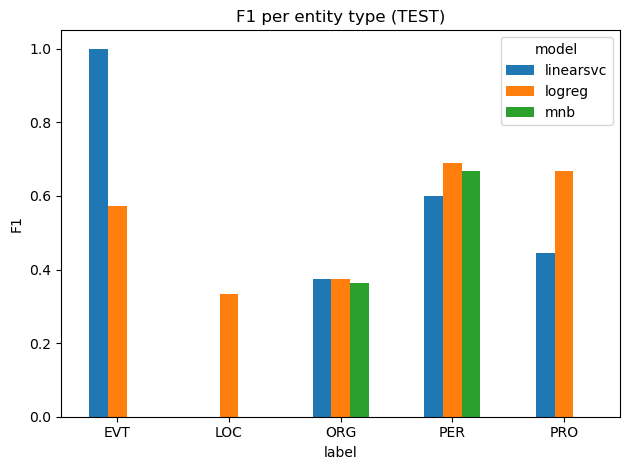

In [33]:
import matplotlib.pyplot as plt

def per_class_f1(y_true, y_pred):
    p, r, f1, sup = precision_recall_fscore_support(
        y_true, y_pred, labels=labels_all, average=None, zero_division=0
    )
    return pd.DataFrame({
        "label": label_names,
        "precision": p,
        "recall": r,
        "f1": f1,
        "support": sup
    })

# TEST per-class
pcs = []
for m in models.keys():
    dfm = per_class_f1(y_te, preds["test"][m])
    dfm["model"] = m
    pcs.append(dfm)
per_class_test = pd.concat(pcs, ignore_index=True)
display(per_class_test)

# plot: F1 per label, grouped by model
pivot_f1 = per_class_test.pivot(index="label", columns="model", values="f1").loc[label_names]
pivot_f1.plot(kind="bar")
plt.title("F1 per entity type (TEST)")
plt.ylabel("F1")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


,model,document_id,n_rows,acc,macro_f1_present
2,linearsvc,ru-1000,14,0.571429,0.509524
0,logreg,ru-1000,14,0.500000,0.392121
4,mnb,ru-1000,14,0.428571,0.177778
1,logreg,ru-1011,18,0.611111,0.713333
3,linearsvc,ru-1011,18,0.444444,0.460000
5,mnb,ru-1011,18,0.611111,0.228148


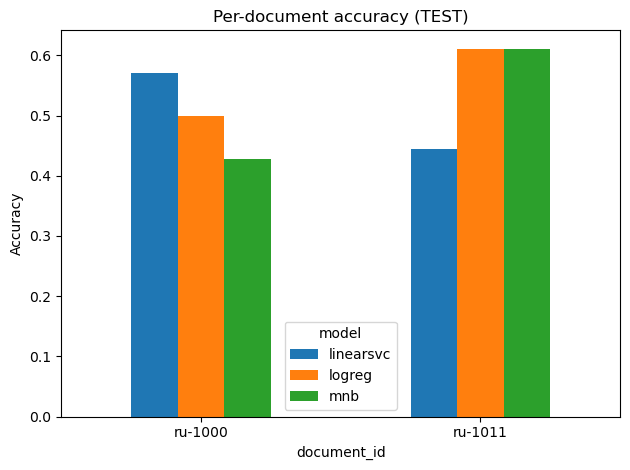

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def macro_f1_present_labels(y_true, y_pred):
    """Macro-F1 only over labels that appear in y_true (for this document)."""
    present = np.unique(y_true)
    return f1_score(y_true, y_pred, labels=present, average="macro", zero_division=0)

doc_rows = []
doc_ids = df_test["document_id"].values

for m in models.keys():
    y_pred = preds["test"][m]
    for doc_id in sorted(df_test["document_id"].unique()):
        idx = (df_test["document_id"].values == doc_id)
        yt = y_te[idx]
        yp = y_pred[idx]
        doc_rows.append({
            "model": m,
            "document_id": doc_id,
            "n_rows": int(idx.sum()),
            "acc": accuracy_score(yt, yp),
            "macro_f1_present": macro_f1_present_labels(yt, yp),
        })

doc_df = pd.DataFrame(doc_rows)
display(doc_df.sort_values(["document_id","macro_f1_present"], ascending=[True,False]))

# plot: per-doc accuracy
pivot_doc = doc_df.pivot(index="document_id", columns="model", values="acc").sort_index()
pivot_doc.plot(kind="bar")
plt.title("Per-document accuracy (TEST)")
plt.ylabel("Accuracy")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


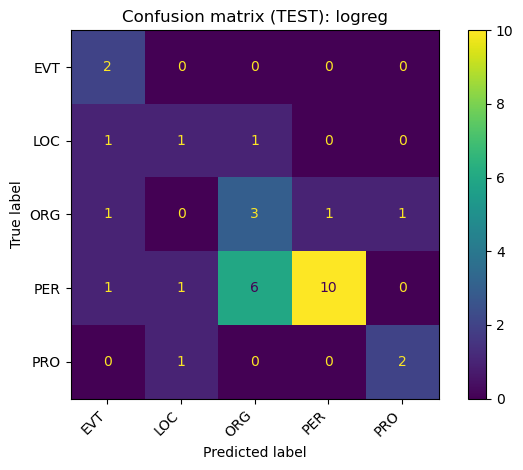

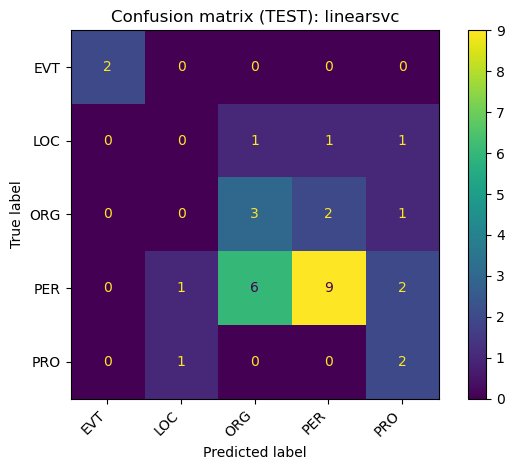

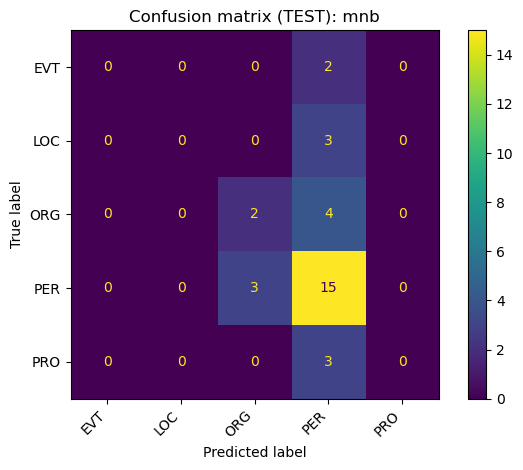

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

for m in models.keys():
    cm = confusion_matrix(y_te, preds["test"][m], labels=labels_all)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(values_format="d")
    plt.title(f"Confusion matrix (TEST): {m}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

DeepSeek coverage on TEST: 0.71875
DeepSeek strict accuracy: 0.625
Matched-only rows: 23 / 32

DeepSeek report (matched-only):
              precision    recall  f1-score   support

         EVT      1.000     1.000     1.000         2
         LOC      0.667     1.000     0.800         2
         ORG      0.714     0.833     0.769         6
         PER      1.000     1.000     1.000        11
         PRO      0.000     0.000     0.000         2

    accuracy                          0.870        23
   macro avg      0.676     0.767     0.714        23
weighted avg      0.810     0.870     0.835        23



C:\Users\Alex\AppData\Local\Temp\ipykernel_18064\1406875343.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  doc_ds = matched.groupby("document_id").apply(


,document_id,n_rows,acc
0,ru-1000,13.0,0.846154
1,ru-1011,10.0,0.900000


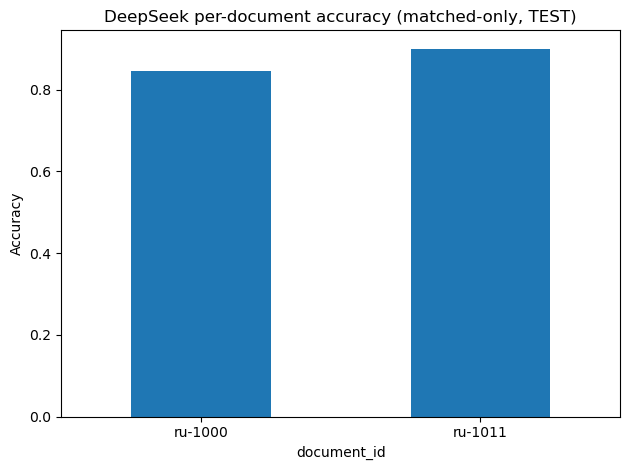

In [36]:
from sklearn.metrics import classification_report

# requires df (full) with deepseek_pred + df_test keys
if "df" not in globals() or "deepseek_pred" not in df.columns:
    raise ValueError("Need global `df` with column `deepseek_pred` (Task 4).")

# test slice with deepseek
test_ds = df.merge(
    df_test[["document_id","entity","gold_answer"]],
    on=["document_id","entity","gold_answer"],
    how="inner"
).copy()

test_ds["deepseek_pred"] = test_ds["deepseek_pred"].fillna("").astype(str)
test_ds["has_pred"] = test_ds["deepseek_pred"].str.len().gt(0)
coverage = test_ds["has_pred"].mean() if len(test_ds) else 0.0
print("DeepSeek coverage on TEST:", coverage)

# (A) strict: empty => wrong
dummy = "__NONE__"
strict_pred = test_ds["deepseek_pred"].where(test_ds["deepseek_pred"].isin(label_names), other=dummy)
strict_acc = (strict_pred == test_ds["gold_answer"]).mean()
print("DeepSeek strict accuracy:", strict_acc)

# (B) matched-only report
matched = test_ds[test_ds["has_pred"] & test_ds["deepseek_pred"].isin(label_names)].copy()
print("Matched-only rows:", len(matched), "/", len(test_ds))

if len(matched):
    print("\nDeepSeek report (matched-only):")
    print(classification_report(
        matched["gold_answer"], matched["deepseek_pred"],
        labels=label_names,
        digits=3,
        zero_division=0
    ))

    # per-doc accuracy for matched-only
    doc_ds = matched.groupby("document_id").apply(
        lambda g: pd.Series({
            "n_rows": len(g),
            "acc": (g["gold_answer"] == g["deepseek_pred"]).mean()
        })
    ).reset_index()
    display(doc_ds)

    # plot per-doc
    doc_ds.set_index("document_id")["acc"].plot(kind="bar")
    import matplotlib.pyplot as plt
    plt.title("DeepSeek per-document accuracy (matched-only, TEST)")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


### Task 7
**Bias-Variance Analysis**

Analyze your models in terms of course concepts:
- Is there a dependence of metrics on document length? Build graphs to answer the question.
- Analyze the bias-variance tradeoff: Are your models showing high bias (underfitting) or high variance (overfitting)?
- Compare train vs test performance. What does this tell you about generalization?
- If you observe overfitting, what could you do to reduce it? (e.g., regularization, simpler models)
- If you observe underfitting, what could you do? (e.g., more features, more complex models)


## ✅ Markdown cell (вставь как Markdown)

### Task 7 — Bias-Variance Analysis

**1) Зависимость качества от длины документа**
Проверяю гипотезу: чем длиннее документ, тем легче классифицировать тип сущности (больше контекста), но длинные тексты могут быть сложнее из-за большего разнообразия сущностей/тем.
Чтобы не делать вывод по 2 тест-документам, считаю *per-document метрики* через **LeaveOneGroupOut по `document_id`** и строю scatter-графики `doc_len` → `macro-F1 (per doc)` + корреляции. Такой подход исключает leakage и даёт 9 точек (по 9 документам). ([Scikit-learn][1])

**2) Bias–variance по train vs test**
Смотрю на разрыв метрик между train и test: большой разрыв = высокая дисперсия (overfitting), низкие метрики и на train, и на test = высокий bias (underfitting). Это стандартная логика анализа через кривые/счета обучения. ([Scikit-learn][2])

По твоим числам (из Task 6):

* **LinearSVC:** train macro-F1 ≈ 0.99, test ≈ 0.48 → **явный overfitting / высокая variance**. Регуляризацию можно усилить, уменьшая `C`. ([Scikit-learn][3])
* **LogReg:** train ≈ 0.73, test ≈ 0.53 → **лучше обобщает** (меньше разрыв). В sklearn регуляризация включена по умолчанию. ([Scikit-learn][4])
* **MultinomialNB:** train ≈ 0.61, test ≈ 0.21 → **скорее underfitting / высокий bias** (слишком простой и/или неподходящие допущения). ([Scikit-learn][5])

**3) Что делать, если overfitting (высокая variance)**

* усилить регуляризацию (уменьшить `C` у LinearSVC/LogReg) ([Scikit-learn][6])
* уменьшить размерность (снизить `max_features`, поднять `min_df`)
* упростить признаки (например, только (1,1) n-граммы)
* добавить данных (больше документов) / использовать GroupCV для более стабильной оценки ([Scikit-learn][1])

**4) Что делать, если underfitting (высокий bias)**

* добавить признаки (символьные n-граммы, расширить контекст, добавить биграммы/триграммы)
* ослабить регуляризацию (увеличить `C`) — осторожно, может усилить overfitting ([Scikit-learn][6])
* использовать более информативную разметку/контекст (например, шаблоны вокруг mention)

Classes: ['EVT', 'LOC', 'ORG', 'PER', 'PRO']


,document_id,doc_len_chars,n_mentions,n_unique_mentions,n_types
0,ru-10,5088,44,44,4
7,ru-1011,1542,18,18,5
5,ru-1004,1028,18,18,4
8,ru-1017,875,14,14,5
6,ru-1006,783,13,13,5
1,ru-1000,778,14,14,5
2,ru-1001,639,13,13,4
4,ru-1003,400,10,10,4
3,ru-1002,316,7,7,4


,model,document_id,n_rows,acc,macro_f1_present,doc_len_chars,n_mentions,n_unique_mentions,n_types
13,linearsvc,ru-1003,10,0.800000,0.791667,400,10,10,4
16,linearsvc,ru-1011,18,0.611111,0.713333,1542,18,18,5
11,linearsvc,ru-1001,13,0.692308,0.589286,639,13,13,4
17,linearsvc,ru-1017,14,0.642857,0.582857,875,14,14,5
14,linearsvc,ru-1004,18,0.722222,0.552083,1028,18,18,4
10,linearsvc,ru-1000,14,0.571429,0.509524,778,14,14,5
9,linearsvc,ru-10,44,0.431818,0.485564,5088,44,44,4
15,linearsvc,ru-1006,13,0.461538,0.446667,783,13,13,5
12,linearsvc,ru-1002,7,0.714286,0.437500,316,7,7,4
5,logreg,ru-1004,18,0.722222,0.701465,1028,18,18,4


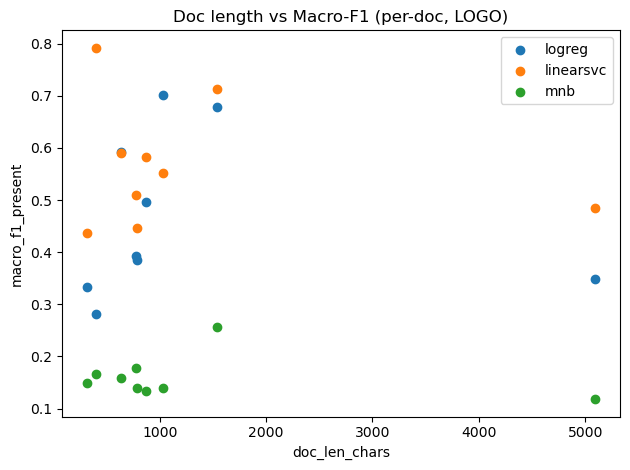

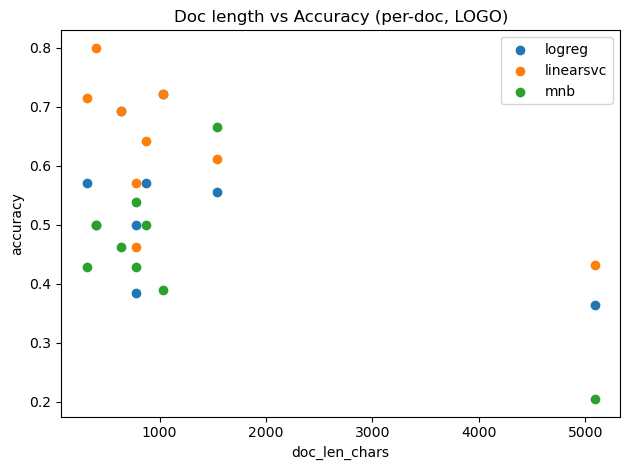

,model,corr_len_f1,corr_len_acc
0,logreg,-0.097774,-0.505432
1,linearsvc,-0.193664,-0.654579
2,mnb,-0.231544,-0.643192


,model,macro_f1_train,macro_f1_test,gap_train_minus_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test
1,linearsvc,0.993695,0.483889,0.509806,0.990826,0.50000,0.992593,0.533333
2,mnb,0.614819,0.206061,0.408758,0.779817,0.53125,0.583044,0.233333
0,logreg,0.726798,0.527217,0.199581,0.798165,0.56250,0.872401,0.611111


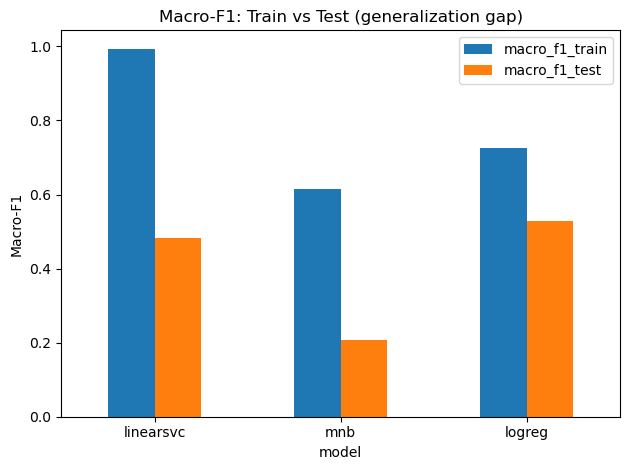

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

# =========================
# Checks
# =========================
need_cols = {"document_id", "document_text", "text_for_ml", "gold_answer"}
if "df" not in globals():
    raise ValueError("Нужен глобальный df (из Task 2).")
missing = need_cols - set(df.columns)
if missing:
    raise ValueError(f"df missing columns: {missing}")

if "le" not in globals():
    raise ValueError("Нужен le (LabelEncoder) из Task 3/4.")

# фиксированный список меток
labels_all = np.arange(len(le.classes_))
label_names = list(le.classes_)
print("Classes:", label_names)

# =========================
# 1) Doc-level stats (len + mentions)
# =========================
doc_meta = (
    df.groupby("document_id")
      .agg(
          doc_len_chars=("document_text", lambda x: len(str(x.iloc[0]))),
          n_mentions=("entity", "size"),
          n_unique_mentions=("entity", lambda x: x.nunique()),
          n_types=("gold_answer", lambda x: x.nunique()),
      )
      .reset_index()
)

display(doc_meta.sort_values("doc_len_chars", ascending=False))

# =========================
# 2) Leave-One-Document-Out (LOGO) per-document performance
#    - to get 9 points for length→quality analysis
# =========================
logo = LeaveOneGroupOut()

# модели (как в твоих baseline)
model_builders = {
    "logreg":   lambda: LogisticRegression(max_iter=3000, class_weight="balanced"),
    "linearsvc":lambda: LinearSVC(class_weight="balanced"),
    "mnb":      lambda: MultinomialNB(alpha=0.5),
}

def macro_f1_present_labels(y_true, y_pred):
    """Macro-F1 only over labels that appear in y_true for this doc."""
    present = np.unique(y_true)
    return f1_score(y_true, y_pred, labels=present, average="macro", zero_division=0)

records = []

X_text = df["text_for_ml"].astype(str).values
y = le.transform(df["gold_answer"].astype(str).values)
groups = df["document_id"].values

for model_name, build in model_builders.items():
    for tr_idx, te_idx in logo.split(X_text, y, groups=groups):
        tr_text = X_text[tr_idx]
        te_text = X_text[te_idx]

        # fit vectorizer ONLY on train fold (no leakage)
        vec = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
        Xtr = vec.fit_transform(tr_text)
        Xte = vec.transform(te_text)

        ytr = y[tr_idx]
        yte = y[te_idx]
        doc_id = groups[te_idx][0]

        clf = build()
        clf.fit(Xtr, ytr)
        pred = clf.predict(Xte)

        records.append({
            "model": model_name,
            "document_id": doc_id,
            "n_rows": int(len(te_idx)),
            "acc": accuracy_score(yte, pred),
            "macro_f1_present": macro_f1_present_labels(yte, pred),
        })

logo_df = pd.DataFrame(records).merge(doc_meta, on="document_id", how="left")
display(logo_df.sort_values(["model", "macro_f1_present"], ascending=[True, False]))

# =========================
# 3) Plots: length vs quality
# =========================
plt.figure()
for model_name in model_builders.keys():
    sub = logo_df[logo_df["model"] == model_name].sort_values("doc_len_chars")
    plt.scatter(sub["doc_len_chars"], sub["macro_f1_present"], label=model_name)
plt.title("Doc length vs Macro-F1 (per-doc, LOGO)")
plt.xlabel("doc_len_chars")
plt.ylabel("macro_f1_present")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for model_name in model_builders.keys():
    sub = logo_df[logo_df["model"] == model_name].sort_values("doc_len_chars")
    plt.scatter(sub["doc_len_chars"], sub["acc"], label=model_name)
plt.title("Doc length vs Accuracy (per-doc, LOGO)")
plt.xlabel("doc_len_chars")
plt.ylabel("accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# correlations (Pearson) - tiny N, so interpret осторожно
corr_rows = []
for model_name in model_builders.keys():
    sub = logo_df[logo_df["model"] == model_name]
    if sub["doc_len_chars"].nunique() > 1:
        r_f1 = np.corrcoef(sub["doc_len_chars"], sub["macro_f1_present"])[0,1]
        r_acc = np.corrcoef(sub["doc_len_chars"], sub["acc"])[0,1]
    else:
        r_f1, r_acc = np.nan, np.nan
    corr_rows.append({"model": model_name, "corr_len_f1": r_f1, "corr_len_acc": r_acc})

corr_df = pd.DataFrame(corr_rows)
display(corr_df)

# =========================
# 4) Bias–variance via train vs test gap (from your current split)
#    Uses existing df_tr/df_test + saved models, if present
# =========================
if "df_tr" in globals() and "df_test" in globals():
    from joblib import load
    import os
    from sklearn.metrics import balanced_accuracy_score

    MODEL_DIR = "models"
    if os.path.isdir(MODEL_DIR):
        vectorizer = load(os.path.join(MODEL_DIR, "tfidf_vectorizer.joblib"))
        le2 = load(os.path.join(MODEL_DIR, "label_encoder.joblib"))

        # ensure same mapping
        assert list(le2.classes_) == list(le.classes_), "LabelEncoder classes mismatch."

        Xtr = vectorizer.transform(df_tr["text_for_ml"])
        ytr = le.transform(df_tr["gold_answer"])
        Xte = vectorizer.transform(df_test["text_for_ml"])
        yte = le.transform(df_test["gold_answer"])

        gap_rows = []
        for m in ["logreg", "linearsvc", "mnb"]:
            clf = load(os.path.join(MODEL_DIR, f"{m}.joblib"))
            ptr = clf.predict(Xtr)
            pte = clf.predict(Xte)

            f1_tr = f1_score(ytr, ptr, labels=labels_all, average="macro", zero_division=0)
            f1_te = f1_score(yte, pte, labels=labels_all, average="macro", zero_division=0)

            gap_rows.append({
                "model": m,
                "macro_f1_train": f1_tr,
                "macro_f1_test": f1_te,
                "gap_train_minus_test": f1_tr - f1_te,
                "acc_train": accuracy_score(ytr, ptr),
                "acc_test": accuracy_score(yte, pte),
                "balanced_acc_train": balanced_accuracy_score(ytr, ptr),
                "balanced_acc_test": balanced_accuracy_score(yte, pte),
            })

        gap_df = pd.DataFrame(gap_rows).sort_values("gap_train_minus_test", ascending=False)
        display(gap_df)

        pivot = gap_df.set_index("model")[["macro_f1_train","macro_f1_test"]]
        pivot.plot(kind="bar")
        plt.title("Macro-F1: Train vs Test (generalization gap)")
        plt.ylabel("Macro-F1")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("models/ folder not found — skipping train-vs-test gap table.")
else:
    print("df_tr/df_test not found — skipping train-vs-test gap table.")


## Task 7 — Bias–Variance: краткий вывод

- **Зависимость качества от длины документа:** по scatter-графикам видно отрицательную связь `doc_len_chars` с качеством (особенно accuracy): самый длинный документ (`ru-10`) даёт худшие метрики. Вероятно, в длинных текстах больше «шума» и разнообразных сущностей, а данных мало.
- **Bias–variance tradeoff:**
  - **LinearSVC:** почти идеальный train (macro-F1≈0.99) и заметно хуже test (≈0.48) → **высокая variance / переобучение**.
  - **MultinomialNB:** низко и на train, и на test (macro-F1≈0.61/0.21) → **высокий bias / недообучение**.
  - **LogisticRegression:** умеренный train и лучший test среди sklearn (macro-F1≈0.73/0.53) → **лучше обобщает**.
- **Generalization:** большой train→test gap (особенно у LinearSVC) говорит, что модель “подгоняется” под train и хуже переносится на новые документы; оценки нестабильны из-за всего **9 документов**.
- **Как уменьшить переобучение:** усилить регуляризацию (уменьшить `C`), уменьшить `max_features`, убрать биграммы, добавить больше документов/данных, делать CV по документам.
- **Как бороться с недообучением:** добавить более информативные признаки (например, символьные n-граммы), улучшить контекст (окно вокруг сущности), увеличить данные.

**Итог:** при текущем размере данных наиболее устойчивый выбор — **LogisticRegression**; **LinearSVC** явно переобучается, **MNB** недообучается.


### Task 8
**Error Analysis & Model Interpretation**

Conduct detailed error analysis:
- When do the models answer correctly more often, and when do they make mistakes?
- Analyze errors by entity type, document characteristics, etc.
- Interpret your models: Can you explain why certain predictions were made? (e.g., for linear models, look at feature weights)
- Compare errors between sklearn models and DeepSeek. What patterns do you see?
- Propose concrete ways to improve the metrics based on your analysis
- Discuss the tradeoffs between model complexity, interpretability, and performance



# Task 8 — Error Analysis & Model Interpretation
Что делаем
1) Собираем таблицу ошибок на TEST (gold vs pred) для всех sklearn-моделей + DeepSeek
2) Анализируем ошибки по: типам сущностей, документам, признакам entity и длине документа
3) Интерпретируем модели: top features (веса) по классам + локальное объяснение для конкретной ошибки
4) Сравниваем паттерны ошибок sklearn vs DeepSeek и предлагаем улучшения


In [38]:
import os
import numpy as np
import pandas as pd

from joblib import load
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

# ---- checks ----
for v in ["df_test"]:
    if v not in globals():
        raise ValueError(f"Missing `{v}`. Run Tasks 2–4 first.")

MODEL_DIR = "models"
vectorizer = load(os.path.join(MODEL_DIR, "tfidf_vectorizer.joblib"))
le = load(os.path.join(MODEL_DIR, "label_encoder.joblib"))

model_files = ["logreg.joblib", "linearsvc.joblib", "mnb.joblib"]
models = {fn.replace(".joblib", ""): load(os.path.join(MODEL_DIR, fn)) for fn in model_files}

label_names = list(le.classes_)
labels_all = np.arange(len(label_names))

# ---- build X_test ----
if "text_for_ml" not in df_test.columns:
    raise ValueError("df_test must contain `text_for_ml` (from Task 2/3).")

X_test = vectorizer.transform(df_test["text_for_ml"])
y_test = le.transform(df_test["gold_answer"])

# ---- base eval df ----
eval_df = df_test[["document_id", "entity", "gold_answer", "document_text", "text_for_ml"]].copy()
eval_df["gold"] = eval_df["gold_answer"].astype(str)

# doc/entity characteristics
eval_df["doc_len_chars"] = eval_df["document_text"].astype(str).str.len()
eval_df["entity_len_chars"] = eval_df["entity"].astype(str).str.len()
eval_df["entity_is_multiword"] = eval_df["entity"].astype(str).str.contains(r"\s+", regex=True)
eval_df["entity_has_digits"] = eval_df["entity"].astype(str).str.contains(r"\d", regex=True)
eval_df["entity_is_allcaps_lat"] = eval_df["entity"].astype(str).str.fullmatch(r"[A-Z][A-Z0-9\-]*", na=False)

# ---- predictions per sklearn model ----
for name, clf in models.items():
    pred_y = clf.predict(X_test)
    eval_df[f"pred_{name}"] = le.inverse_transform(pred_y)
    eval_df[f"ok_{name}"] = (eval_df[f"pred_{name}"] == eval_df["gold"])

eval_df.head()


,document_id,entity,gold_answer,document_text,text_for_ml,gold,doc_len_chars,entity_len_chars,entity_is_multiword,entity_has_digits,entity_is_allcaps_lat,pred_logreg,ok_logreg,pred_linearsvc,ok_linearsvc,pred_mnb,ok_mnb
0,ru-1000,Brexit,EVT,"Таким образом, Джонсон стал третьим министром,...",Brexit ||| р по вопросам выхода Великобритании...,EVT,778,6,False,False,False,EVT,True,EVT,True,PER,False
1,ru-1000,The Guardian,PRO,"Таким образом, Джонсон стал третьим министром,...",The Guardian ||| м коллективную позицию относи...,PRO,778,12,True,False,False,PRO,True,PRO,True,PER,False
2,ru-1000,Борис Джонсон,PER,"Таким образом, Джонсон стал третьим министром,...",Борис Джонсон ||| Борис Джонсон,PER,778,13,True,False,False,PER,True,PER,True,PER,True
3,ru-1000,Бориса Джонсона,PER,"Таким образом, Джонсон стал третьим министром,...",Бориса Джонсона ||| ии Тереза Мэй пообещала от...,PER,778,15,True,False,False,ORG,False,ORG,False,ORG,False
4,ru-1000,Бориса,PER,"Таким образом, Джонсон стал третьим министром,...",Бориса ||| ии Тереза Мэй пообещала отправить в...,PER,778,6,False,False,False,ORG,False,ORG,False,ORG,False



## 1) Где модели чаще правы / ошибаются (ошибки по типам)


In [39]:
def per_label_error_table(df: pd.DataFrame, model: str) -> pd.DataFrame:
    pred_col = f"pred_{model}"
    ok_col = f"ok_{model}"
    out = []
    for lab in sorted(df["gold"].unique()):
        part = df[df["gold"] == lab]
        if len(part) == 0:
            continue
        acc = part[ok_col].mean()
        out.append({"model": model, "label": lab, "n": len(part), "accuracy": acc, "error_rate": 1-acc})
    return pd.DataFrame(out).sort_values(["error_rate", "n"], ascending=[False, False])

tables = []
for m in models.keys():
    tables.append(per_label_error_table(eval_df, m))
err_by_label = pd.concat(tables, ignore_index=True)
err_by_label


,model,label,n,accuracy,error_rate
0,logreg,LOC,3,0.333333,0.666667
1,logreg,ORG,6,0.500000,0.500000
2,logreg,PER,18,0.555556,0.444444
3,logreg,PRO,3,0.666667,0.333333
4,logreg,EVT,2,1.000000,0.000000
5,linearsvc,LOC,3,0.000000,1.000000
6,linearsvc,PER,18,0.500000,0.500000
7,linearsvc,ORG,6,0.500000,0.500000
8,linearsvc,PRO,3,0.666667,0.333333
9,linearsvc,EVT,2,1.000000,0.000000


In [41]:
# top confusion pairs for each model
def top_confusions(df: pd.DataFrame, model: str, topn: int = 10) -> pd.DataFrame:
    pred_col = f"pred_{model}"
    ok_col = f"ok_{model}"
    err = df[~df[ok_col]].copy()
    if err.empty:
        return pd.DataFrame(columns=["gold", "pred", "count"])
    out = (err.groupby(["gold", pred_col]).size()
           .sort_values(ascending=False)
           .head(topn)
           .reset_index(name="count")
           .rename(columns={pred_col: "pred"}))
    return out

for m in models.keys():
    print("\n", "="*20, m, "="*20)
    display(top_confusions(eval_df, m, topn=12))



 ==================== logreg ====================


,gold,pred,count
0,PER,ORG,6
1,LOC,EVT,1
2,LOC,ORG,1
3,ORG,PER,1
4,ORG,EVT,1
5,ORG,PRO,1
6,PER,EVT,1
7,PER,LOC,1
8,PRO,LOC,1



 ==================== linearsvc ====================


,gold,pred,count
0,PER,ORG,6
1,PER,PRO,2
2,ORG,PER,2
3,LOC,ORG,1
4,LOC,PER,1
5,ORG,PRO,1
6,LOC,PRO,1
7,PER,LOC,1
8,PRO,LOC,1



 ==================== mnb ====================


,gold,pred,count
0,ORG,PER,4
1,PER,ORG,3
2,LOC,PER,3
3,PRO,PER,3
4,EVT,PER,2


## 2) Ошибки по характеристикам сущности (multiword/цифры/ALLCAPS)
Идея: понять, например, что multiword чаще PER/ORG и где модели путаются.

In [43]:
def group_acc(df: pd.DataFrame, model: str, col: str) -> pd.DataFrame:
    ok_col = f"ok_{model}"
    return (df.groupby(col)[ok_col]
            .agg(n="size", accuracy="mean")
            .reset_index()
            .sort_values("accuracy", ascending=True))

for m in models.keys():
    print("\n", "="*20, m, "entity_is_multiword", "="*20)
    display(group_acc(eval_df, m, "entity_is_multiword"))

    print("\n", "="*20, m, "entity_has_digits", "="*20)
    display(group_acc(eval_df, m, "entity_has_digits"))

    print("\n", "="*20, m, "entity_is_allcaps_lat", "="*20)
    display(group_acc(eval_df, m, "entity_is_allcaps_lat"))



 ==================== logreg entity_is_multiword ====================


,entity_is_multiword,n,accuracy
0,False,16,0.4375
1,True,16,0.6875



 ==================== logreg entity_has_digits ====================


,entity_has_digits,n,accuracy
0,False,32,0.5625



 ==================== logreg entity_is_allcaps_lat ====================


,entity_is_allcaps_lat,n,accuracy
0,False,32,0.5625



 ==================== linearsvc entity_is_multiword ====================


,entity_is_multiword,n,accuracy
0,False,16,0.3125
1,True,16,0.6875



 ==================== linearsvc entity_has_digits ====================


,entity_has_digits,n,accuracy
0,False,32,0.5



 ==================== linearsvc entity_is_allcaps_lat ====================


,entity_is_allcaps_lat,n,accuracy
0,False,32,0.5



 ==================== mnb entity_is_multiword ====================


,entity_is_multiword,n,accuracy
0,False,16,0.3125
1,True,16,0.7500



 ==================== mnb entity_has_digits ====================


,entity_has_digits,n,accuracy
0,False,32,0.53125



 ==================== mnb entity_is_allcaps_lat ====================


,entity_is_allcaps_lat,n,accuracy
0,False,32,0.53125



 ## 3) Ошибки vs длина документа
 Смотрим зависимость качества от doc_len_chars: корреляция и примеры "длинные доки хуже".


In [44]:
import matplotlib.pyplot as plt

# doc-level aggregation on TEST
doc_stats = (eval_df.groupby("document_id")
             .agg(doc_len_chars=("doc_len_chars", "first"),
                  n_mentions=("gold", "size"))
             .reset_index())

doc_stats


,document_id,doc_len_chars,n_mentions
0,ru-1000,778,14
1,ru-1011,1542,18


In [45]:
# per-doc accuracy per model + merge length
doc_rows = []
for m in models.keys():
    ok_col = f"ok_{m}"
    tmp = (eval_df.groupby("document_id")[ok_col]
           .agg(n_rows="size", acc="mean")
           .reset_index())
    tmp["model"] = m
    doc_rows.append(tmp)

doc_acc = pd.concat(doc_rows, ignore_index=True).merge(doc_stats, on="document_id", how="left")
doc_acc


,document_id,n_rows,acc,model,doc_len_chars,n_mentions
0,ru-1000,14,0.500000,logreg,778,14
1,ru-1011,18,0.611111,logreg,1542,18
2,ru-1000,14,0.571429,linearsvc,778,14
3,ru-1011,18,0.444444,linearsvc,1542,18
4,ru-1000,14,0.428571,mnb,778,14
5,ru-1011,18,0.611111,mnb,1542,18


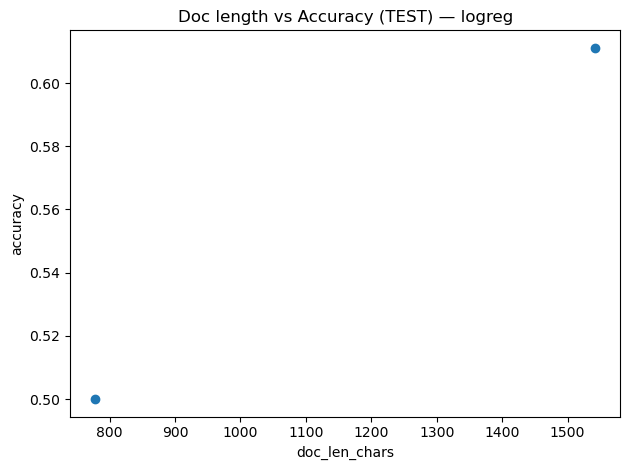

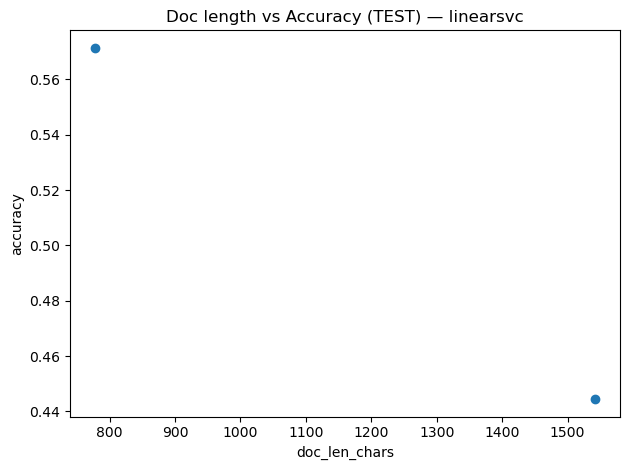

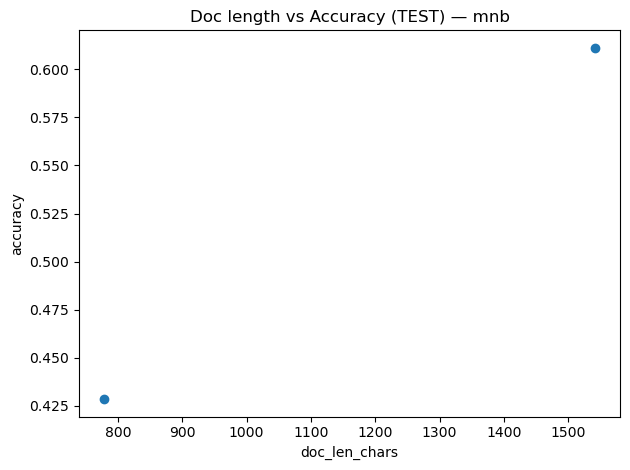

,model,corr_len_acc
0,logreg,1.0
1,linearsvc,-1.0
2,mnb,1.0


In [46]:
# scatter: doc_len vs per-doc accuracy
for m in models.keys():
    part = doc_acc[doc_acc["model"] == m]
    plt.figure()
    plt.scatter(part["doc_len_chars"], part["acc"])
    plt.title(f"Doc length vs Accuracy (TEST) — {m}")
    plt.xlabel("doc_len_chars")
    plt.ylabel("accuracy")
    plt.tight_layout()
    plt.show()

# correlations (Pearson)
corr_rows = []
for m in models.keys():
    part = doc_acc[doc_acc["model"] == m]
    corr = np.corrcoef(part["doc_len_chars"], part["acc"])[0,1] if len(part) >= 2 else np.nan
    corr_rows.append({"model": m, "corr_len_acc": corr})
pd.DataFrame(corr_rows)



 ## 4) Интерпретация моделей (почему предсказали так?)
 Для линейных моделей sklearn доступны веса `coef_`:
 - LogisticRegression: `coef_` (n_classes x n_features) :contentReference[oaicite:0]{index=0}
 - LinearSVC: `coef_` для linear SVM :contentReference[oaicite:1]{index=1}
 Для MultinomialNB можно смотреть `feature_log_prob_` (лог-вероятности по классам) :contentReference[oaicite:2]{index=2}


In [47]:
feature_names = np.array(vectorizer.get_feature_names_out())

def top_features_linear(clf, class_idx: int, topn: int = 20) -> pd.DataFrame:
    if not hasattr(clf, "coef_"):
        raise ValueError("Model has no coef_")
    w = clf.coef_[class_idx]
    top = np.argsort(w)[-topn:][::-1]
    bot = np.argsort(w)[:topn]
    return pd.DataFrame({
        "top_feature": feature_names[top],
        "top_weight": w[top],
        "bottom_feature": feature_names[bot],
        "bottom_weight": w[bot],
    })

# show for logreg + linearsvc
for m in ["logreg", "linearsvc"]:
    clf = models[m]
    print("\n", "="*25, m, "="*25)
    for i, lab in enumerate(label_names):
        print(f"\nClass: {lab}")
        display(top_features_linear(clf, i, topn=12))



 ========================= logreg =========================

Class: EVT


,top_feature,top_weight,bottom_feature,bottom_weight
0,brexit,1.527049,иностранных,-0.292888
1,brexit brexit,0.546735,иностранных дел,-0.289585
2,брекзит,0.480277,дел,-0.289585
3,брекзита,0.362326,бориса,-0.275546
4,брекзиту,0.346648,мид,-0.268296
5,который,0.341644,министра иностранных,-0.257450
6,брексит,0.298224,бориса джонсона,-0.248163
7,по,0.277228,дел великобритании,-0.228103
8,или,0.277146,отставку,-0.224284
9,от взглядов,0.271267,facebook,-0.223503



Class: LOC


,top_feature,top_weight,bottom_feature,bottom_weight
0,лондоне,0.321532,brexit,-0.560907
1,северную,0.244962,мэй,-0.384210
2,единой,0.236990,мид,-0.328383
3,ирландию,0.236012,отставку,-0.291243
4,германии,0.227995,россии,-0.234404
5,балкан,0.226772,мид россии,-0.234404
6,западных,0.226772,мария,-0.228605
7,западных балкан,0.226772,мария захарова,-0.228605
8,польши,0.226288,тереза мэй,-0.226941
9,европы,0.196974,дэвис,-0.225373



Class: ORG


,top_feature,top_weight,bottom_feature,bottom_weight
0,мид,0.554321,brexit,-0.378120
1,евросоюзом,0.413838,guardian,-0.290555
2,ес,0.350062,the,-0.290555
3,мид британии,0.325640,the guardian,-0.290555
4,евросоюза,0.320346,facebook,-0.278201
5,после,0.312071,бориса,-0.255062
6,мид великобритании,0.269160,джонсона,-0.228068
7,что,0.256189,джонсона уйти,-0.226065
8,ее,0.226595,великобритании бориса,-0.226065
9,партии,0.215516,уйти отставку,-0.226065



Class: PER


,top_feature,top_weight,bottom_feature,bottom_weight
0,мэй,0.565401,brexit,-0.386916
1,тереза,0.516017,facebook официальный,-0.259219
2,тереза мэй,0.444014,the guardian,-0.206239
3,джонсон,0.435799,the,-0.206239
4,борис джонсон,0.347279,guardian,-0.206239
5,борис,0.347279,сообщает the,-0.201915
6,министр,0.264195,ал отставку,-0.190660
7,дэвис,0.253561,guardian ал,-0.190660
8,бориса,0.235828,ал,-0.190660
9,за работу,0.232700,мид,-0.189926



Class: PRO


,top_feature,top_weight,bottom_feature,bottom_weight
0,facebook,0.893096,brexit,-0.201106
1,the,0.880649,джонсон,-0.194480
2,the guardian,0.880649,его,-0.166206
3,guardian,0.880649,борис,-0.164724
4,facebook официальный,0.789163,борис джонсон,-0.164724
5,дел великобритании,0.655774,мэй,-0.153266
6,бориса джонсона,0.620707,на,-0.150213
7,guardian ал,0.596708,по,-0.144807
8,ал отставку,0.596708,тереза,-0.118254
9,ал,0.596708,подал,-0.113376



 ========================= linearsvc =========================

Class: EVT


,top_feature,top_weight,bottom_feature,bottom_weight
0,brexit,1.736117,поясом смертника,-0.593867
1,брекзит,0.802003,развития отношений,-0.445411
2,brexit облагодарила,0.616592,отношений,-0.445411
3,облагодарила джонсона,0.616592,дэвис ранее,-0.434410
4,облагодарила,0.616592,соединенного,-0.302997
5,брекзиту,0.613612,соединенного королевства,-0.302997
6,брекзит вросоюза,0.599976,евросоюза,-0.252623
7,вросоюза,0.599976,после,-0.251298
8,вросоюза ранее,0.599976,дэвис,-0.243479
9,брекзиту смертника,0.524760,миш,-0.228790



Class: LOC


,top_feature,top_weight,bottom_feature,bottom_weight
0,киев киев,0.476964,мэй,-0.548127
1,лондоне,0.451509,brexit,-0.527361
2,лирический скл,0.438587,мид,-0.524305
3,скл,0.438587,камне,-0.415727
4,минис,0.408705,на камне,-0.415727
5,премьер минис,0.408705,тереза мэй,-0.363191
6,великобритании министр,0.408705,мид британии,-0.333875
7,великобритании премьер,0.402176,тереза,-0.326789
8,связ,0.402176,унн киев,-0.320570
9,это связ,0.402176,оставит камня,-0.319366



Class: ORG


,top_feature,top_weight,bottom_feature,bottom_weight
0,мид,1.110185,джонсон глава,-0.519341
1,евросоюзом,0.734183,джонсон,-0.519323
2,ес,0.712124,бориса,-0.433381
3,после,0.630747,министра,-0.372377
4,унн киев,0.565181,тереза,-0.356759
5,евросоюза,0.537848,работу,-0.341813
6,мид британии,0.527422,за работу,-0.341813
7,мид великобритании,0.430610,ой,-0.340248
8,унн,0.424194,мэй,-0.336665
9,press иностранных,0.423788,министра страны,-0.334250



Class: PER


,top_feature,top_weight,bottom_feature,bottom_weight
0,джонсон,0.832926,великобритании,-0.597442
1,мэй,0.795504,brexit,-0.507125
2,тереза,0.753301,мид,-0.458315
3,тереза мэй,0.598830,ес,-0.446373
4,бориса,0.597060,press иностранных,-0.341858
5,дэвис,0.561913,качестве возможного,-0.307340
6,сообщ,0.476777,пообещал,-0.293348
7,джонсон киев,0.476777,мэй пообещал,-0.293348
8,этом сообщ,0.476777,brexit по,-0.293348
9,борис,0.474871,связ,-0.292834



Class: PRO


,top_feature,top_weight,bottom_feature,bottom_weight
0,facebook официальный,1.124966,его,-0.381357
1,facebook,0.820209,дел великобрита,-0.374307
2,guardian,0.631438,великобрита,-0.374307
3,the,0.631438,захарова официальный,-0.374307
4,the guardian,0.631438,захарова,-0.326048
5,ал,0.626288,россии официальный,-0.302884
6,guardian ал,0.626288,учитывая,-0.300175
7,ал отставку,0.626288,учитывая его,-0.300175
8,дел великобритании,0.612438,его лирический,-0.300175
9,джонсона уйти,0.591350,лирический,-0.300175


In [48]:
def top_features_mnb(clf, class_idx: int, topn: int = 20) -> pd.DataFrame:
    # high log prob features for class
    lp = clf.feature_log_prob_[class_idx]
    top = np.argsort(lp)[-topn:][::-1]
    return pd.DataFrame({"feature": feature_names[top], "log_prob": lp[top]})

if "mnb" in models:
    clf = models["mnb"]
    for i, lab in enumerate(label_names):
        print(f"\nMNB class: {lab}")
        display(top_features_mnb(clf, i, topn=12))



MNB class: EVT


,feature,log_prob
0,brexit,-5.951380
1,brexit brexit,-6.618263
2,по,-6.725479
3,брекзит,-6.758384
4,брекзита,-6.796441
5,дэвид дэвис,-6.843574
6,дэвид,-6.843574
7,дэвис,-6.855537
8,на,-6.863444
9,который,-6.864836



MNB class: LOC


,feature,log_prob
0,на,-6.322081
1,великобритании,-6.505499
2,лондоне,-6.547522
3,по,-6.600898
4,дел,-6.611287
5,иностранных дел,-6.611287
6,иностранных,-6.620080
7,джонсон,-6.638424
8,германии,-6.716658
9,польши,-6.717153



MNB class: ORG


,feature,log_prob
0,мид,-6.107098
1,отставку,-6.444219
2,что,-6.463225
3,великобритании,-6.507551
4,ес,-6.522727
5,евросоюза,-6.535549
6,на,-6.558244
7,евросоюзом,-6.565389
8,премьер,-6.611285
9,мид великобритании,-6.631212



MNB class: PER


,feature,log_prob
0,мэй,-5.794590
1,тереза,-5.965478
2,джонсон,-5.972128
3,отставку,-6.022367
4,министр,-6.035499
5,тереза мэй,-6.067011
6,премьер,-6.068442
7,джонсона,-6.097602
8,министра,-6.114630
9,борис джонсон,-6.128686



MNB class: PRO


,feature,log_prob
0,facebook,-6.894934
1,the guardian,-6.909663
2,the,-6.909663
3,guardian,-6.909663
4,бориса джонсона,-6.985220
5,дел великобритании,-6.985220
6,facebook официальный,-7.013191
7,отставку,-7.016310
8,бориса,-7.017790
9,министра иностранных,-7.034005


 ## 5) Локальное объяснение ошибки (какие фичи "толкнули" в pred vs gold)
 Для линейных моделей можно разложить вклад признаков: contribution = x_i * weight.


In [50]:
def explain_instance_linear(clf, x_row, gold_label: str, topn: int = 12):
    if not hasattr(clf, "coef_"):
        raise ValueError("Model has no coef_")

    # predicted class by decision scores
    scores = clf.decision_function(x_row)
    if scores.ndim == 1:
        pred_idx = int(scores.argmax())
    else:
        pred_idx = int(scores[0].argmax())

    gold_idx = label_names.index(gold_label)

    idx = x_row.indices
    vals = x_row.data

    # contributions for pred and gold
    w_pred = clf.coef_[pred_idx, idx]
    w_gold = clf.coef_[gold_idx, idx]

    contrib_pred = vals * w_pred
    contrib_gold = vals * w_gold

    # top features by contribution
    top_pred = np.argsort(contrib_pred)[-topn:][::-1]
    top_gold = np.argsort(contrib_gold)[-topn:][::-1]

    df_pred = pd.DataFrame({
        "feature": feature_names[idx[top_pred]],
        "x": vals[top_pred],
        "w": w_pred[top_pred],
        "contrib": contrib_pred[top_pred],
    })

    df_gold = pd.DataFrame({
        "feature": feature_names[idx[top_gold]],
        "x": vals[top_gold],
        "w": w_gold[top_gold],
        "contrib": contrib_gold[top_gold],
    })

    return pred_idx, label_names[pred_idx], df_pred, df_gold

# pick one misclassified example for logreg
m = "logreg"
wrong = eval_df[~eval_df[f"ok_{m}"]].copy()
wrong.head()


,document_id,entity,gold_answer,document_text,text_for_ml,gold,doc_len_chars,entity_len_chars,entity_is_multiword,entity_has_digits,entity_is_allcaps_lat,pred_logreg,ok_logreg,pred_linearsvc,ok_linearsvc,pred_mnb,ok_mnb
3,ru-1000,Бориса Джонсона,PER,"Таким образом, Джонсон стал третьим министром,...",Бориса Джонсона ||| ии Тереза Мэй пообещала от...,PER,778,15,True,False,False,ORG,False,ORG,False,ORG,False
4,ru-1000,Бориса,PER,"Таким образом, Джонсон стал третьим министром,...",Бориса ||| ии Тереза Мэй пообещала отправить в...,PER,778,6,False,False,False,ORG,False,ORG,False,ORG,False
5,ru-1000,Великобритании,LOC,"Таким образом, Джонсон стал третьим министром,...",Великобритании ||| пост в течении суток. Ранн...,LOC,778,14,False,False,False,EVT,False,PER,False,PER,False
7,ru-1000,Дэвид Дэвис,PER,"Таким образом, Джонсон стал третьим министром,...",Дэвид Дэвис ||| . Раннее о своем уходе объявил...,PER,778,11,True,False,False,EVT,False,PER,True,PER,True
8,ru-1000,ЕС,ORG,"Таким образом, Джонсон стал третьим министром,...",ЕС ||| ток. Раннее о своем уходе объявили мини...,ORG,778,2,False,False,False,EVT,False,PER,False,PER,False


In [51]:
# Show explanation for the first error
if len(wrong):
    i = wrong.index[0]
    row = eval_df.loc[i]
    x_row = X_test[df_test.index.get_loc(i)] if (i in df_test.index) else X_test[0]

    pred_idx, pred_lab, df_pred, df_gold = explain_instance_linear(models[m], x_row, row["gold"], topn=10)

    print("document_id:", row["document_id"])
    print("entity:", row["entity"])
    print("GOLD:", row["gold"])
    print("PRED:", pred_lab)

    print("\nTop contributions toward PRED:")
    display(df_pred)

    print("\nTop contributions toward GOLD:")
    display(df_gold)
else:
    print("No errors for this model on TEST (unlikely, but possible).")


document_id: ru-1000
entity: Бориса Джонсона
GOLD: PER
PRED: ORG

Top contributions toward PRED:


,feature,x,w,contrib
0,мид,0.113103,0.554321,0.062695
1,ее,0.147736,0.226595,0.033476
2,если он,0.163061,0.205270,0.033471
3,джонсона если,0.163061,0.205270,0.033471
4,если,0.154627,0.168612,0.026072
5,позицию,0.173934,0.144560,0.025144
6,мид соединенного,0.173934,0.127830,0.022234
7,отправить отставку,0.163061,0.117213,0.019113
8,он,0.136862,0.135655,0.018566
9,согласованную ее,0.189259,0.080953,0.015321



Top contributions toward GOLD:


,feature,x,w,contrib
0,тереза,0.110664,0.516017,0.057104
1,тереза мэй,0.118512,0.444014,0.052621
2,бориса,0.204460,0.235828,0.048217
3,мэй,0.083302,0.565401,0.047099
4,джонсона,0.164348,0.166859,0.027423
5,мэй пообещала,0.154627,0.065879,0.010187
6,пообещала,0.154627,0.065879,0.010187
7,отправить,0.154627,0.065879,0.010187
8,пообещала отправить,0.154627,0.065879,0.010187
9,королевства бориса,0.173934,0.035451,0.006166



 ## 6) Сравнение ошибок sklearn vs DeepSeek
 DeepSeek у тебя добавлен в `df['deepseek_pred']` (и может быть пустым).
 Сравним:
 - где logreg ошибся, а DeepSeek угадал
 - где наоборот
 - какие типы сущностей чаще “спасает” DeepSeek


In [53]:
if "df" in globals() and "deepseek_pred" in df.columns:
    test_ds = df.merge(
        df_test[["document_id", "entity", "gold_answer"]],
        on=["document_id", "entity", "gold_answer"],
        how="inner"
    ).copy()

    test_ds["deepseek_pred"] = test_ds["deepseek_pred"].fillna("").astype(str)
    test_ds["deepseek_has"] = test_ds["deepseek_pred"].isin(label_names)

    # attach to eval_df
    eval2 = eval_df.merge(
        test_ds[["document_id", "entity", "gold_answer", "deepseek_pred", "deepseek_has"]],
        on=["document_id", "entity", "gold_answer"],
        how="left"
    )

    base_model = "logreg"  # по твоим метрикам он лучший на TEST
    eval2["ok_base"] = eval2[f"ok_{base_model}"]
    eval2["ok_deepseek"] = (eval2["deepseek_pred"] == eval2["gold"]) & eval2["deepseek_has"]

    # 4-case table
    def case(r):
        if r["ok_base"] and r["ok_deepseek"]:
            return "both_correct"
        if r["ok_base"] and (not r["ok_deepseek"]):
            return "sklearn_only"
        if (not r["ok_base"]) and r["ok_deepseek"]:
            return "deepseek_only"
        return "both_wrong"

    eval2["case"] = eval2.apply(case, axis=1)

    print("DeepSeek coverage (valid label) on TEST:", eval2["deepseek_has"].mean())
    display(eval2["case"].value_counts())

    # where DeepSeek helps
    helped = eval2[eval2["case"] == "deepseek_only"].copy()
    print("\nDeepSeek-only correct examples:", len(helped))
    display(helped[["document_id", "entity", "gold", f"pred_{base_model}", "deepseek_pred", "doc_len_chars"]].head(20))

    # by entity type
    by_type = (eval2.groupby(["gold","case"]).size().reset_index(name="count"))
    display(by_type.sort_values(["gold","count"], ascending=[True, False]))

else:
    print("Need global `df` with column `deepseek_pred` to compare with DeepSeek.")


DeepSeek coverage (valid label) on TEST: 0.71875


case
both_correct     12
deepseek_only     8
sklearn_only      6
both_wrong        6
Name: count, dtype: int64


DeepSeek-only correct examples: 8


,document_id,entity,gold,pred_logreg,deepseek_pred,doc_len_chars
3,ru-1000,Бориса Джонсона,PER,ORG,PER,778
4,ru-1000,Бориса,PER,ORG,PER,778
5,ru-1000,Великобритании,LOC,EVT,LOC,778
7,ru-1000,Дэвид Дэвис,PER,EVT,PER,778
8,ru-1000,ЕС,ORG,EVT,ORG,778
13,ru-1000,УНН,ORG,PRO,ORG,778
28,ru-1011,Палате общин,ORG,PER,ORG,1542
31,ru-1011,Терезы Мэй,PER,ORG,PER,1542


,gold,case,count
0,EVT,both_correct,2
1,LOC,both_correct,1
2,LOC,both_wrong,1
3,LOC,deepseek_only,1
5,ORG,deepseek_only,3
4,ORG,both_correct,2
6,ORG,sklearn_only,1
7,PER,both_correct,7
8,PER,both_wrong,4
9,PER,deepseek_only,4


 ## 7) Рекомендации по улучшению (конкретно из ошибок)
 Ниже - заготовка, которую ты можешь подстроить под увиденные у тебя топ-конфьюжны и примеры.

 Идеи улучшений:
 1) **Усилить устойчивость к словоформам (русский):**
    - добавить **char n-grams** (например, analyzer='char_wb', ngram_range=(3,5)) в TF-IDF
    - или сделать лемматизацию (pymorphy2/stanza) и векторизовать леммы
 2) **Тюнить регуляризацию**:
    - для LinearSVC уменьшить C / ограничить max_features (снизить переобучение)
    - для LogReg подобрать C и penalty (обычно помогает на маленьких данных)
 3) **Больше данных и корректнее CV**:
    - при 9 документах метрики очень нестабильны → лучше GroupKFold/LOGO по doc_id
 4) **Фичи для entity отдельно**:
    - добавить признаки формы: caps/digits/длина/кол-во токенов (через FeatureUnion)
 5) **Словари/газеттиры**:
    - списки стран/городов/организаций (миксуется с ML и часто сильно поднимает LOC/ORG)
 6) **Улучшить сравнение с DeepSeek**:
    - нормализация “ЕС/Евросоюзом/Евросоюза”, леммы, более аккуратный fuzzy-match

 Tradeoffs:
 - Linear models + TF-IDF: быстро, прозрачно (coef_ легко объяснять), но ограничены bag-of-words.
 - Нейросети/LLM: часто лучше, но дороже, менее детерминированы и хуже объяснимы + вопросы приватности.


### Task 9
**Conclusions & Reflection**

Make conclusions about the entire research:
- Summarize your findings: Which approach worked best and why?
- Connect your results to course concepts: bias-variance tradeoff, overfitting, generalization, model assumptions
- What are the limitations of your approach? What assumptions did you make?
- What would you do differently if you had more time or data?
- Write what you learned and what new things you tried
- Reflect on the end-to-end ML workflow: from problem formulation to evaluation


## Task 9 — Conclusions & Reflection

### Итоги: что сработало лучше и почему
- Среди **sklearn-моделей** лучшей по **macro-F1 на TEST** оказалась **LogisticRegression** (≈0.53), затем **LinearSVC** (≈0.48), и заметно хуже **MultinomialNB** (≈0.21).
- **DeepSeek** показал очень высокое качество **на “matched-only” части** (macro-F1 ≈0.71 на 23/32 строках), но **coverage** на TEST ≈0.72 и при “strict” оценке (пустые/не-сопоставившиеся ответы = ошибка) точность падает (≈0.63). Поэтому DeepSeek нельзя напрямую сравнивать с sklearn по matched-only: это метрика “качество при наличии ответа”, а не “качество всегда”.

### Связь с концепциями курса (bias–variance, overfitting, generalization)
- **LinearSVC** на TRAIN почти идеален (macro-F1 ≈0.99), но на TEST заметно ниже (≈0.48) → большой **generalization gap** и признаки **высокой вариативности (overfitting / high variance)** на маленьком числе документов.
- **LogisticRegression** имеет меньший разрыв (TRAIN ≈0.73 vs TEST ≈0.53) → более “ровная” обобщаемость на новые документы (лучший компромисс bias–variance в текущей постановке).
- **MultinomialNB** показывает низкий macro-F1 на TEST и слабую balanced accuracy → скорее **high bias / underfitting** для этой постановки (слишком простая модель/допущения + мало данных/сильный дисбаланс).

### Зависимость качества от характеристик документов
- На уровне документов (LOGO) наблюдается **отрицательная связь качества с длиной текста** (корреляция accuracy с doc_len_chars около -0.5…-0.65), а также длинный документ `ru-10` давал худшие результаты у всех моделей. Возможные причины:
  - больше уникальных сущностей и “тем” → сложнее контекст;
  - больше вариантов написания/словоформ → выше шанс промаха при bag-of-words.

### Ограничения и допущения
- Данных очень мало: **9 документов**, поэтому оценки на TEST имеют высокую неопределённость и сильно зависят от того, какие 2 документа попали в test.
- Задача NER упрощена до **классификации типа сущности для (упоминание + контекст)**, а не sequence labeling по токенам.
- Для DeepSeek сравнение приближённое: модель возвращала списки сущностей, а затем мы сопоставляли их с gold-упоминаниями (есть влияние матчинга и coverage).

### Что бы я сделал(а) иначе при большем времени/данных
- Перейти на более устойчивую оценку: **GroupKFold / Leave-One-Group-Out CV** по document_id (и усреднять метрики).
- Настроить гиперпараметры (C у LogReg/LinearSVC), попробовать **char n-grams**, нормализацию, лемматизацию, признаки формы слова.
- Улучшить постановку: брать фиксированный контекст вокруг упоминания, добавить позиционные/символьные фичи.
- Для LLM — просить **классифицировать каждое gold-упоминание** (а не извлекать всё из текста), чтобы сравнение было “яблоки к яблокам”.

### Что я изучил(а) и что нового попробовал(а)
- Полный ML-пайплайн: загрузка сырых данных → сбор DataFrame → защита от leakage (split по документам) → TF-IDF → обучение 3 baseline-моделей → сравнение метрик → кастомная метрика и векторизация → сравнение с LLM.
- Практически увидел(а) bias–variance tradeoff: “очень сильный train” не гарантирует хороший test, особенно на маленьком числе групп (документов).

### Рефлексия end-to-end
Главный вывод: **самое важное в этой задаче — корректная схема разбиения по документам и честная оценка**. На таком маленьком датасете простая, но устойчиво регуляризованная модель (LogReg) часто выигрывает у более “агрессивных” разделяющих моделей. LLM может быть сильным, но для честного сравнения нужна одинаковая постановка и учёт coverage.


In [57]:
import os
import pandas as pd
from joblib import load

# ====== SETTINGS ======
MODEL_DIR = "models"
MODEL_NAME = "linearsvc"   # <-- оставь linearsvc, если выбирал лучшую по VAL в Task 4
OUT_PATH = "predictions_test.csv"
# ======================

# ---- checks ----
if "df_test" not in globals():
    raise ValueError("Не найден df_test. Сначала выполни Task 3 (split).")

required_cols = {"document_id", "entity", "gold_answer", "text_for_ml"}
missing = required_cols - set(df_test.columns)
if missing:
    raise ValueError(f"df_test не содержит нужные колонки: {missing}")

# ---- load artifacts ----
vectorizer = load(os.path.join(MODEL_DIR, "tfidf_vectorizer.joblib"))
le = load(os.path.join(MODEL_DIR, "label_encoder.joblib"))
clf = load(os.path.join(MODEL_DIR, f"{MODEL_NAME}.joblib"))

# ---- build features + predict ----
X_test = vectorizer.transform(df_test["text_for_ml"])
y_pred = clf.predict(X_test)
pred_labels = le.inverse_transform(y_pred)  # обратно в строки меток (PER/ORG/...) 

# ---- save csv ----
pred_df = df_test[["document_id", "entity", "gold_answer"]].copy()
pred_df["pred_answer"] = pred_labels

pred_df.to_csv(OUT_PATH, index=False, encoding="utf-8")
print(f"✅ Saved: {OUT_PATH} | shape={pred_df.shape}")
pred_df.head()


✅ Saved: predictions_test.csv | shape=(32, 4)


,document_id,entity,gold_answer,pred_answer
0,ru-1000,Brexit,EVT,EVT
1,ru-1000,The Guardian,PRO,PRO
2,ru-1000,Борис Джонсон,PER,PER
3,ru-1000,Бориса Джонсона,PER,ORG
4,ru-1000,Бориса,PER,ORG
